# STOCK PRICE PREDICTOR

# Importing necessary libraries

In [1]:
!pip install keras-tuner
!pip install --upgrade keras-tuner
!pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from kerastuner.tuners import Hyperband
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras_tuner import Hyperband
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

import warnings


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


<ipython-input-1-9eaa8ac3bba2>:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


## Importing data from yfinance dataset

In [2]:
# Get the stock ticker for NVIDIA
stock = yf.Ticker("NVDA")

# Get historical market data
data_hist = stock.history(start="2014-01-01", end="2023-12-31", actions=False, rounding=False)

# Set 'Date' as the index of the DataFrame
data_hist.reset_index(inplace=True)
data_hist.set_index('Date', inplace=True)

# Save the DataFrame to a CSV file without the default numerical index
data_hist.to_csv('stock_price_NVDA.csv', index=True)

# Load the data from the CSV, with 'Date' as the index
data = pd.read_csv('stock_price_NVDA.csv', index_col='Date', parse_dates=True)

# Convert 'Date' index to UTC timezone to handle timezone-aware datetime objects
data.index = pd.to_datetime(data.index, utc=True)

# Use the index directly to calculate days, months, and years
data['Days'] = (data.index - data.index.min()).days
data['Month'] = data.index.month
data['Year'] = data.index.year

# Display the first few rows of the updated DataFrame to verify the changes
print(data.head())


                               Open      High       Low     Close    Volume  \
Date                                                                          
2014-01-02 05:00:00+00:00  3.754698  3.768849  3.707529  3.740547  26009200   
2014-01-03 05:00:00+00:00  3.747623  3.754698  3.683944  3.695736  25933200   
2014-01-06 05:00:00+00:00  3.733472  3.773566  3.698095  3.745264  40949200   
2014-01-07 05:00:00+00:00  3.783000  3.820736  3.757057  3.806584  33328800   
2014-01-08 05:00:00+00:00  3.820735  3.877339  3.806584  3.858471  30819200   

                           Days  Month  Year  
Date                                          
2014-01-02 05:00:00+00:00     0      1  2014  
2014-01-03 05:00:00+00:00     1      1  2014  
2014-01-06 05:00:00+00:00     4      1  2014  
2014-01-07 05:00:00+00:00     5      1  2014  
2014-01-08 05:00:00+00:00     6      1  2014  


As we do not need all the columns from the dataframe, we take only the 'Close' price of the stock and transfer it into a new dataframe where we call the column as 'Prices'.

In [3]:
# Only closing price of data

stock_prices = pd.DataFrame(data['Close']).rename(columns={'Close':'Price'})
stock_prices.head()

,Price
Date,
2014-01-02 05:00:00+00:00,3.740547
2014-01-03 05:00:00+00:00,3.695736
2014-01-06 05:00:00+00:00,3.745264
2014-01-07 05:00:00+00:00,3.806584
2014-01-08 05:00:00+00:00,3.858471


# Exploratory Data Analysis (EDA)

**Exploratory Data Analysis (EDA)** is a critical first step in building a model for stock price prediction. It helps you understand the data you're working with and identify patterns that might be useful for prediction. Here's how EDA helps in stock price prediction:


*   **Understanding trends and seasonality**:

  By visualizing the closing prices over time, you can see if there are any upward or downward trends, or seasonal fluctuations. This can help you choose appropriate models for prediction.

*   **Identifying relationships:**

  EDA can help uncover relationships between different features in your data, such as price and volume, or price and specific news events. These relationships can be incorporated into your model to improve accuracy.

*   **Data cleaning and transformation:**

  During EDA, you might identify missing values or outliers in your data. You can then take steps to clean and transform the data to make it more suitable for modeling.
*   **Feature engineering:**

  EDA can inspire the creation of new features based on the existing data. For example, you might calculate the daily return (percentage change in closing price) or moving averages to capture trends.

By performing EDA, we gain a deeper understanding of the factors that influence stock prices in your dataset. This knowledge can then be used to build a more robust and informative model for predicting stock prices.

In [4]:
data.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Days      0
Month     0
Year      0
dtype: int64

In this step we are checking if there is any empty data points in the dataset.
Emplty data points would present a problem especially in time series datasets as it may result in data leakage while training resulting in some predictions as 'NA', as time series models take into consideration the seasonality, so if there is any empty data points it would break the predictions.

## Checking for empty data points,
Checking for empty data points, also known as missing values, is crucial in EDA for time series data for several reasons:

*   **Identifying data collection issues:**

    Empty data points can indicate problems with your data collection process. Maybe a sensor malfunctioned on a specific day, or data wasn't recorded for a particular time period.  This helps you understand the potential limitations of your data.

*   **Understanding data completeness:**

    The presence and frequency of missing values can tell you how complete your data is.  Are there large chunks of missing data, or are they scattered throughout?  This helps determine if the data is suitable for the analysis you want to perform.

*   **Seasonality analysis:**
    
    Empty data points can disrupt the analysis of seasonal patterns.  For instance, if temperature data is missing for all weekends in a year, it can skew the understanding of weekly temperature variations.  Identifying these gaps helps you account for them when analyzing seasonality.

*   **Model selection:**
    
    Some time series models are more sensitive to missing values than others.  Knowing the extent of missing data points helps you choose a model that can handle them appropriately.








This knowledge allows you to clean and pre-process the data effectively before using it for further analysis or modeling.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-01-02 05:00:00+00:00 to 2023-12-29 05:00:00+00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Close   2516 non-null   float64
 4   Volume  2516 non-null   int64  
 5   Days    2516 non-null   int64  
 6   Month   2516 non-null   int32  
 7   Year    2516 non-null   int32  
dtypes: float64(4), int32(2), int64(2)
memory usage: 157.2 KB


## Describe function
**data.describe()** helps in EDA for stock price prediction:

*   **Central Tendency:**
    
    It shows the mean (average) value for each numerical column, giving an idea of the central tendency of features like 'Open', 'High', 'Low', 'Close', and 'Volume'. This can help identify outliers and understand the typical range of stock prices.

*   **Dispersion:**
    
    It provides the standard deviation and quantile information (25th, 50th, and 75th percentiles) for each numerical column. This helps understand the spread or dispersion of stock prices and volume data, which is crucial for modeling volatility.

*   **Range:**

    It displays the minimum and maximum values for each numerical column, revealing the overall range of stock prices and volume over the given time period. This information can guide data preprocessing steps like normalization or scaling.

*   **Missing Values:**
    
    If there are any missing values in the numerical columns, data.describe() will exclude those rows, indicating potential missing data issues that need to be addressed.

*   **Feature Selection:**

    By analyzing the summary statistics, one can identify features with low variance or outliers, which may need to be removed or transformed before modeling.

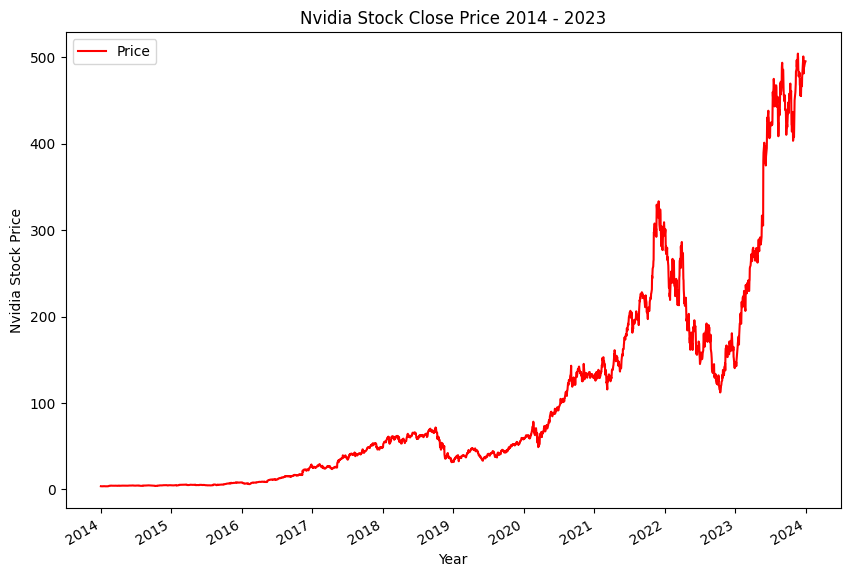

In [ ]:
stock_prices.plot(figsize=(10,7),color='red')
plt.ylabel('Nvidia Stock Price')
plt.xlabel('Year')
plt.title('Nvidia Stock Close Price 2014 - 2023')
plt.show()

## Plotting analysis
Plotting the stock price can help us in various ways. Some uses for plotting the price are:
*   **Trend Identification:**
    
    The line plot of stock prices over time reveals the overall trend, whether the prices are increasing, decreasing, or exhibiting any patterns or cycles. This information is crucial for selecting appropriate time-series modeling techniques and identifying potential predictors.

*   **Volatility Analysis:**
    
    The plot shows the degree of fluctuations or volatility in stock prices, which is an important factor in stock price prediction models. High volatility may require different modeling approaches compared to low volatility scenarios.

*   **Seasonality and Cyclicality:**
    
    The plot can reveal any seasonal or cyclical patterns in the stock prices, which can be incorporated into the prediction models using appropriate techniques like Fourier transformations or seasonal decomposition.

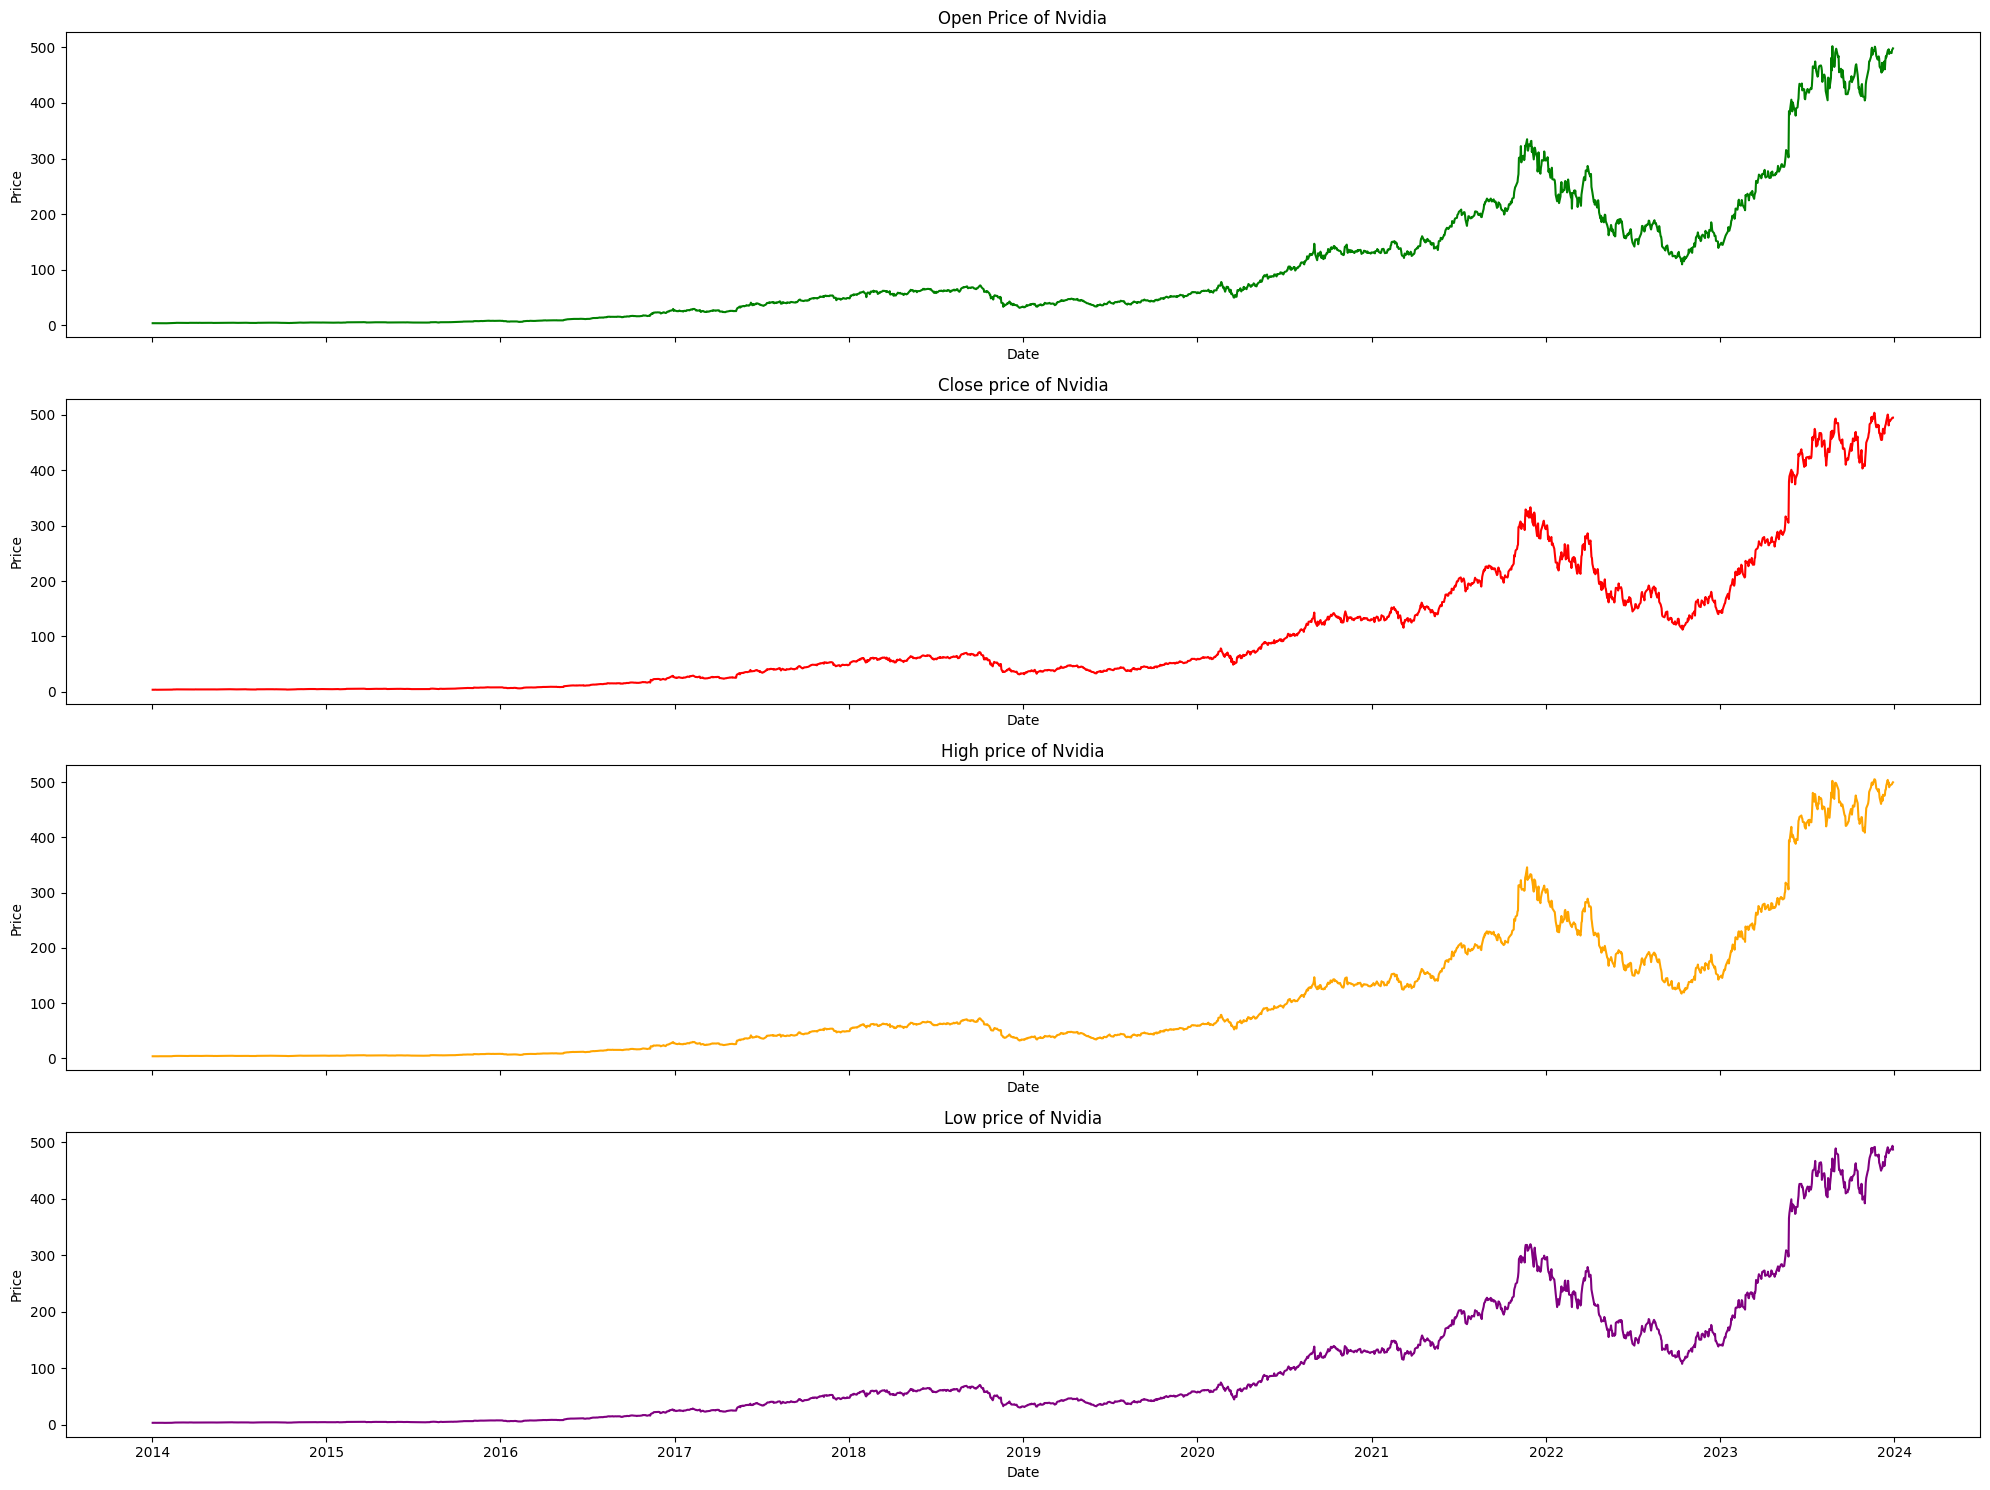

In [ ]:
# Create subplots
fig, ax = plt.subplots(4, 1, figsize=(20, 15), sharex=True)

# Plot each price series
ax[0].plot(data.index, data['Open'], color='green')
ax[1].plot(data.index, data['Close'], color='red')
ax[2].plot(data.index, data['High'], color='orange')
ax[3].plot(data.index, data['Low'], color='purple')

# Customize each subplot
ax[0].set_title('Open Price of NVDA')
ax[1].set_title('Close Price of NVDA')
ax[2].set_title('High Price of NVDA')
ax[3].set_title('Low Price of NVDA')

# Customize subplots
ax[0].set_title('Open Price of Nvidia')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')
ax[1].set_title('Close price of Nvidia')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')
ax[2].set_title('High price of Nvidia')
ax[2].set_xlabel('Date')
ax[2].set_ylabel('Price')
ax[3].set_title('Low price of Nvidia')
ax[3].set_xlabel('Date')
ax[3].set_ylabel('Price')

# Show the plot
plt.tight_layout()
plt.show()

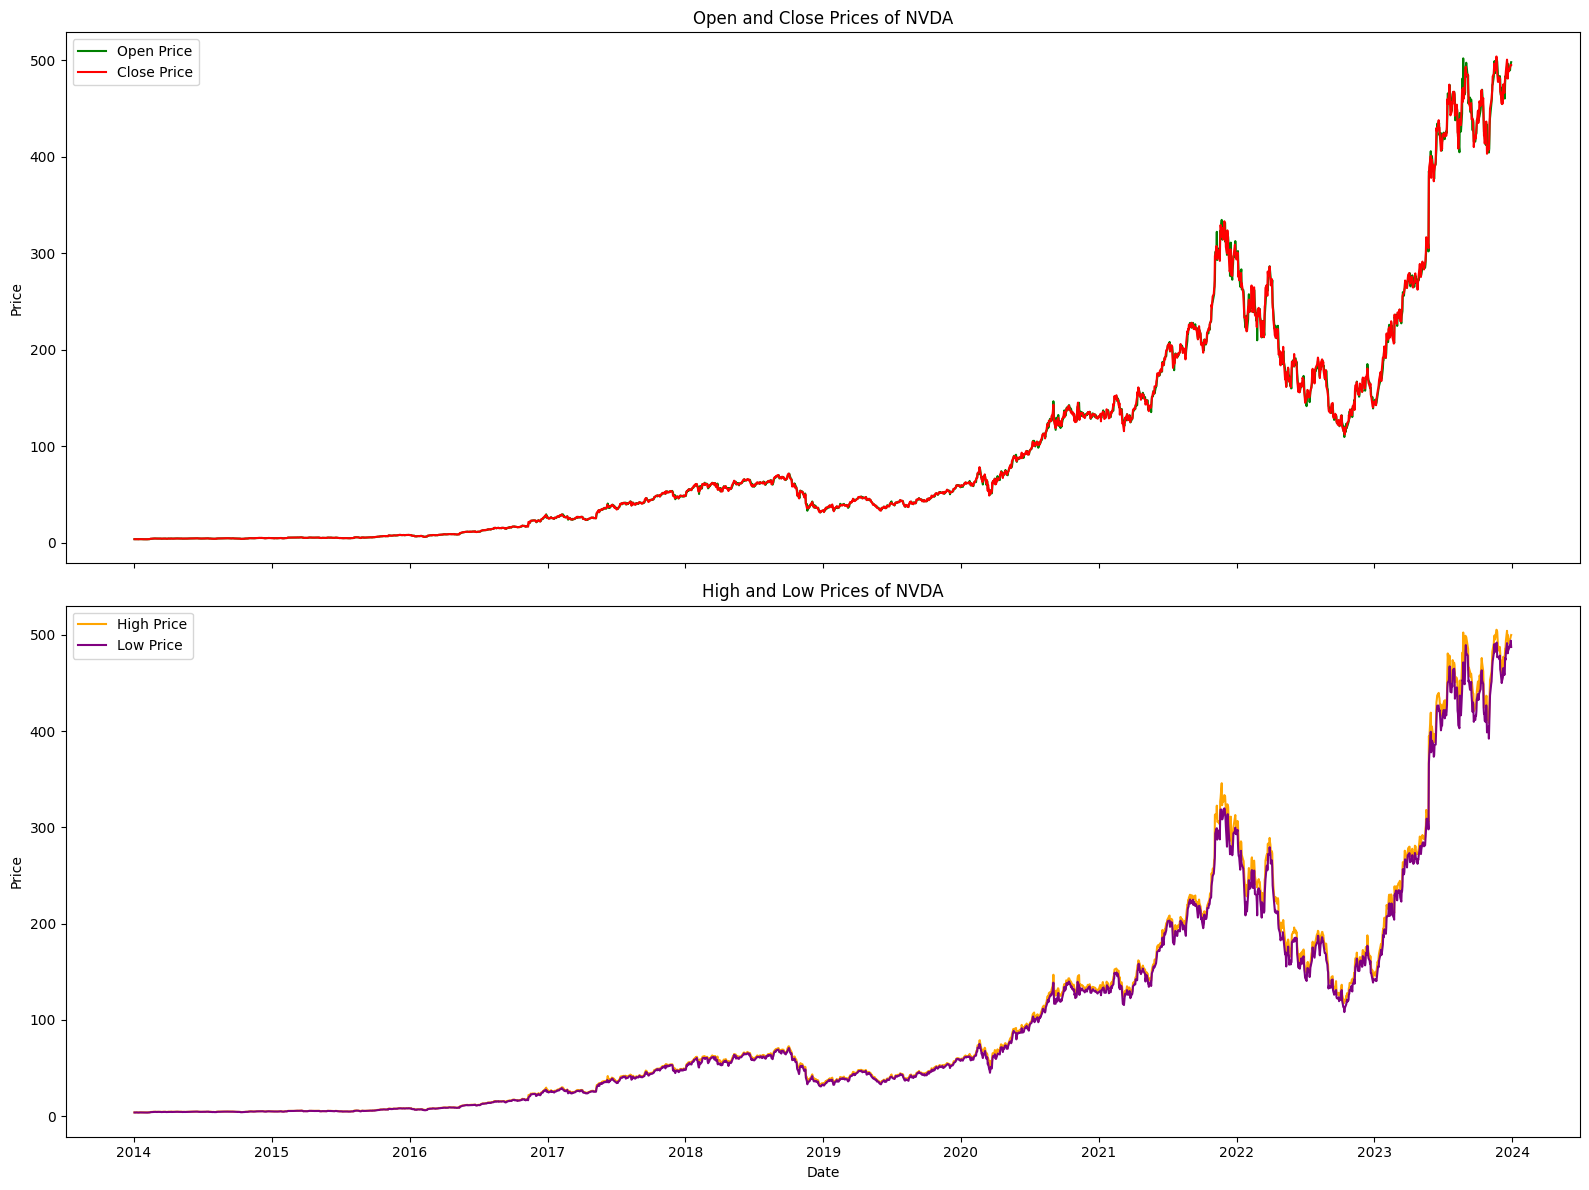

In [ ]:
# Create subplots for stock prices
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(16, 12))

# Plot each price series
ax[0].plot(data.index, data['Open'], color='green', label='Open Price')
ax[0].plot(data.index, data['Close'], color='red', label='Close Price')
ax[0].legend()
ax[1].plot(data.index, data['High'], color='orange', label='High Price')
ax[1].plot(data.index, data['Low'], color='purple', label='Low Price')
ax[1].legend()

# Customize subplots
ax[0].set_title('Open and Close Prices of NVDA')
ax[0].set_ylabel('Price')
ax[1].set_title('High and Low Prices of NVDA')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price')

# Show the plot
plt.tight_layout()
plt.show()

## Visualizing with sns.pairplot()
The sns.pairplot() function creates a matrix of scatter plots, displaying the pairwise relationships between all the features in the dataset.

This visualization can help in:

*   **Correlation Analysis:**

    The scatter plots reveal the strength and direction of the linear relationships between features, which can guide feature selection and identify potential predictors for stock prices.

*   **Distribution Analysis:**
    
    The diagonal plots show the distribution of each feature, helping to identify skewness, multimodality, or other non-normal patterns that may require data transformations.

*   **Outlier Identification:**
    
    Scatter plots can visually highlight any outliers or anomalies in the data, which may need to be addressed before modeling.

*   **Pattern Recognition:**
    
    Patterns or clusters in the scatter plots can reveal underlying structures or relationships in the data, providing insights for feature engineering or model selection.

In [ ]:
# Display Basic Statistics
print("Summary statistics:\n", data.describe())

Summary statistics:
               Open         High          Low        Close        Volume  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03   
mean    100.337689   102.143094    98.463538   100.387268  4.582860e+07   
std     117.962454   119.984031   115.777944   117.956988  2.564292e+07   
min       3.639133     3.660359     3.613189     3.622623  4.564400e+06   
25%      11.683252    11.767974    11.588090    11.678954  2.938990e+07   
50%      51.949121    52.657747    50.849708    51.901316  4.027660e+07   
75%     145.635894   148.407588   142.203173   145.392082  5.520290e+07   
max     502.050924   505.411861   494.096823   504.022034  3.692928e+08   

              Days        Month         Year  
count  2516.000000  2516.000000  2516.000000  
mean   1823.354134     6.546900  2018.496423  
std    1053.956220     3.426099     2.871466  
min       0.000000     1.000000  2014.000000  
25%     909.750000     4.000000  2016.000000  
50%    1825.000000   

Next we can use a pairplot to visualise the data, as a pairplot shows to the relationship between differnet aspects of the data.
It can be used to determine which column from the dataset makes most sense to be used for predictions as not all columns give the best understanding.

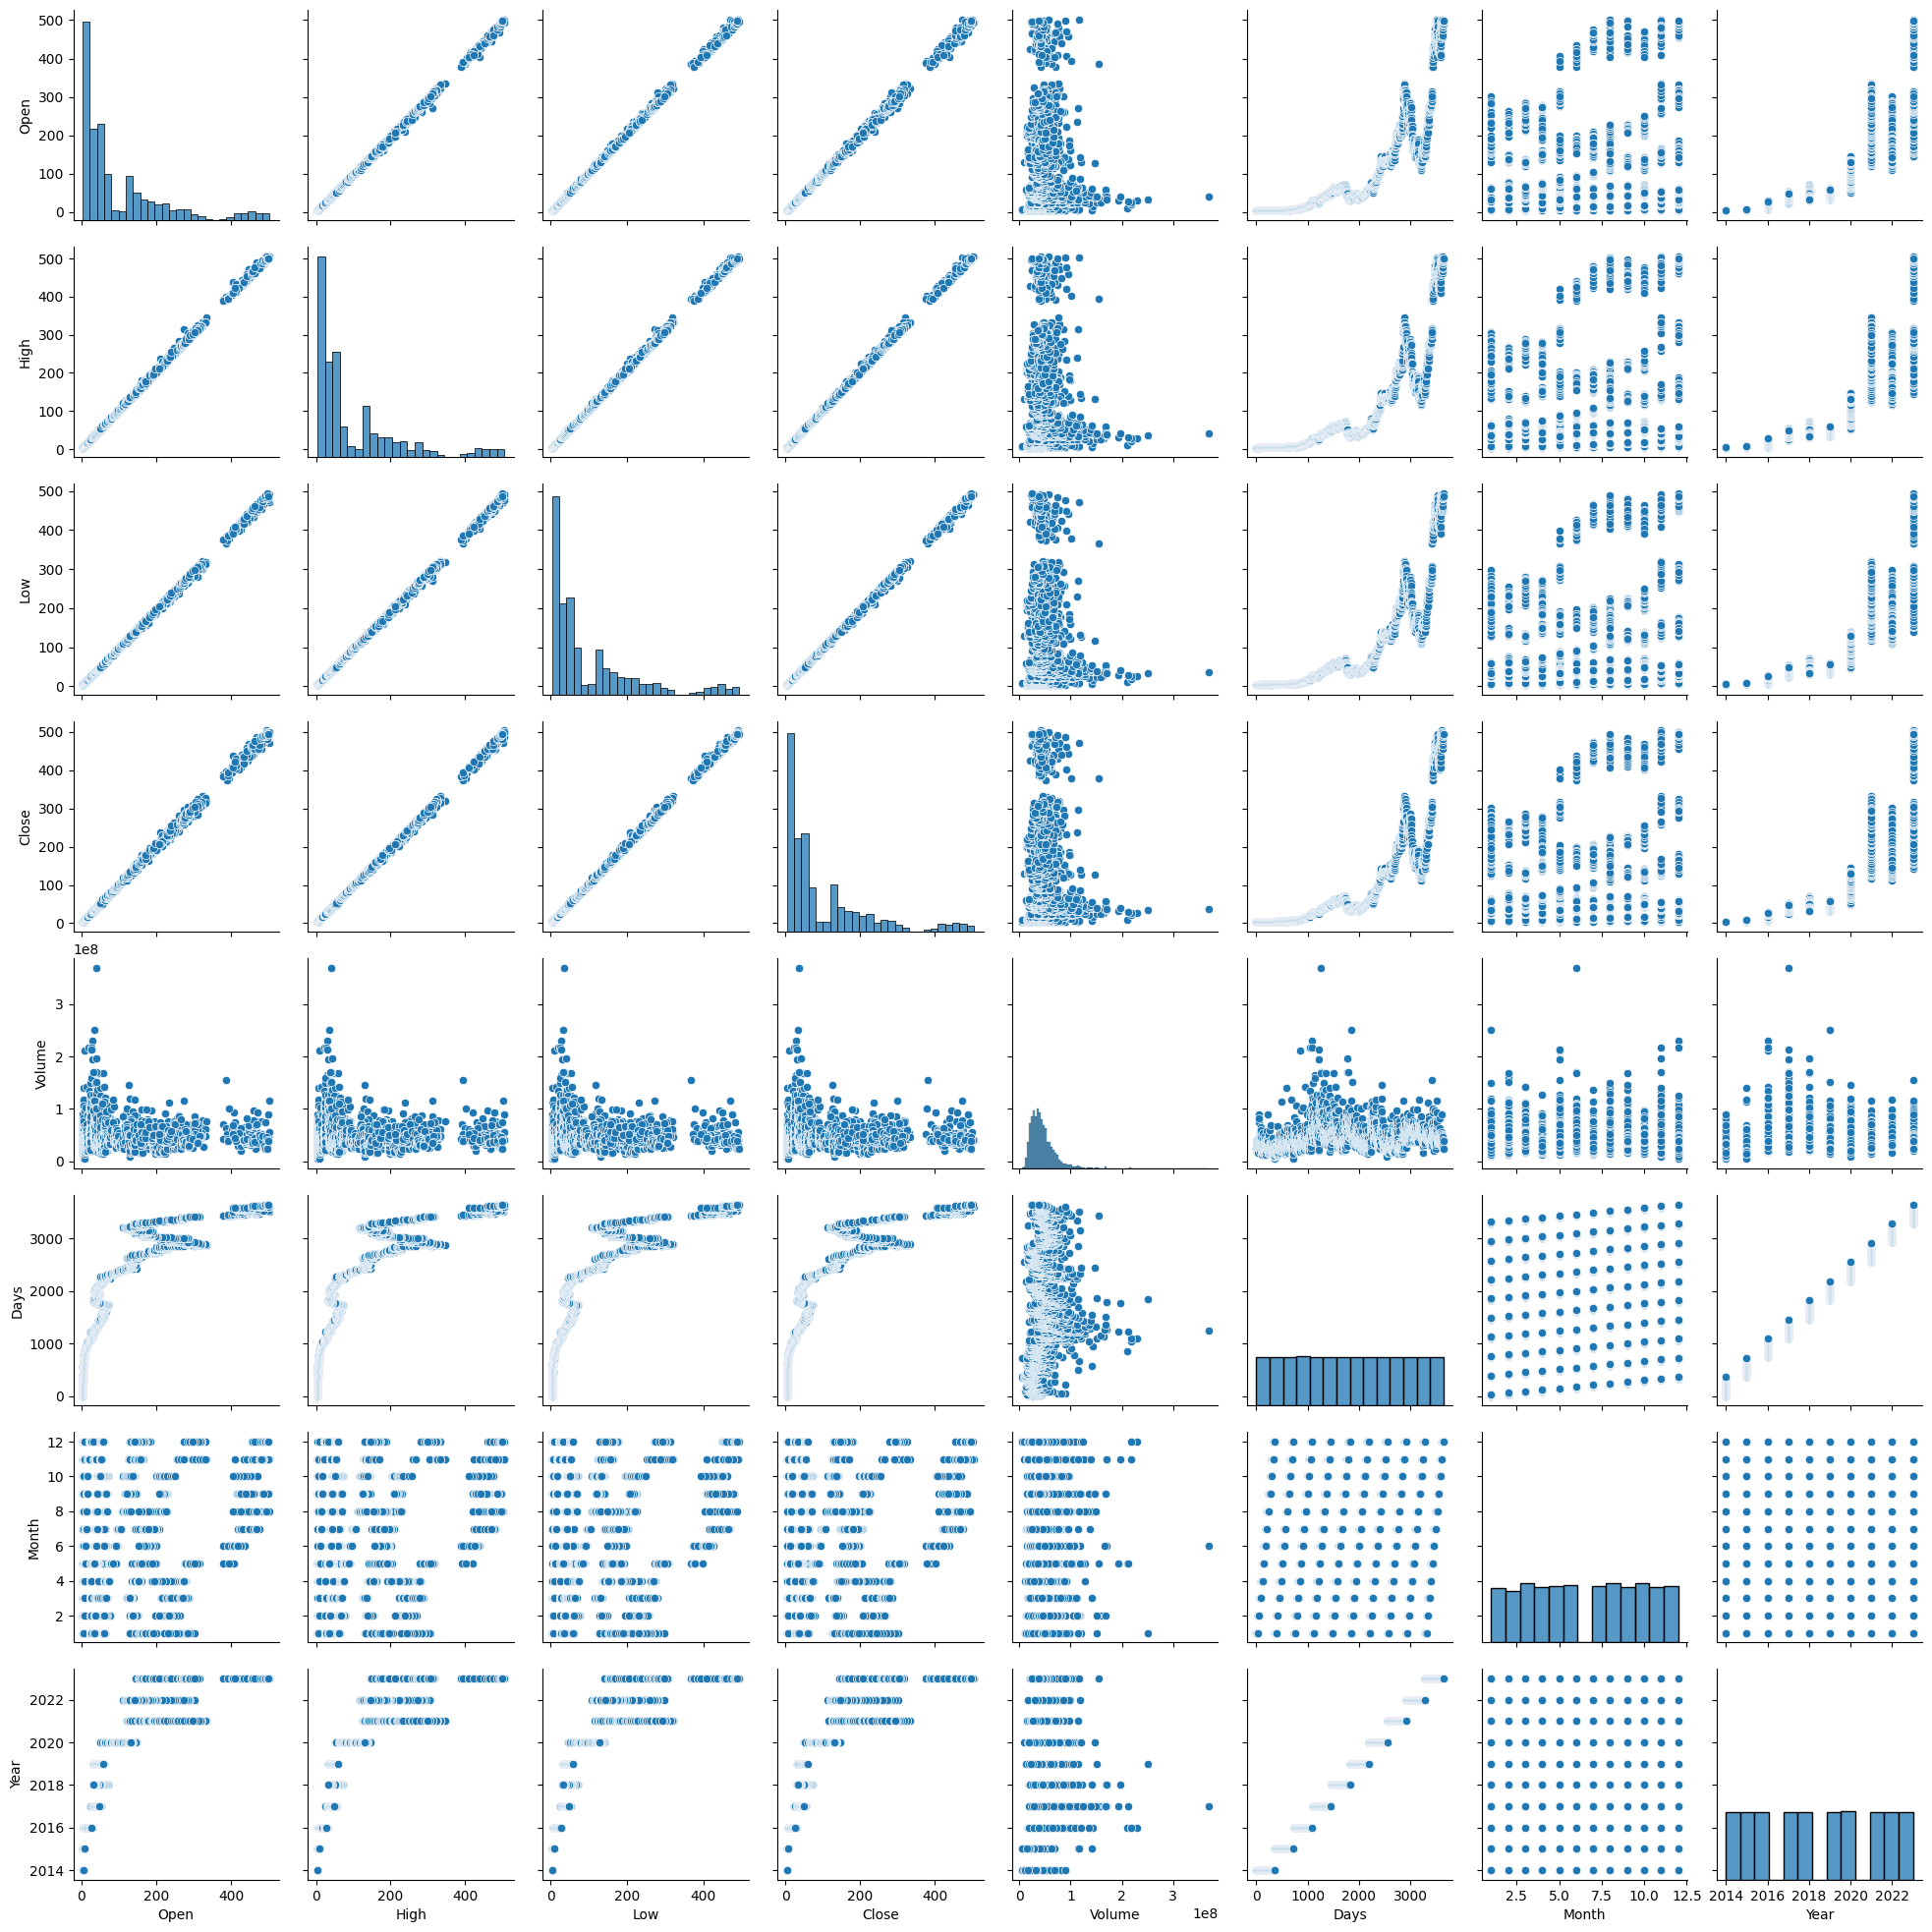

In [ ]:
# Visualize the data with a pairplot
sns.pairplot(data)
plt.show()

From this pairplot, we find it difficult to understand what most pairplots mean, EXCEPT CLOSE vs OTHER plots.
These pairs when visualised give us a more meaningful understanding of how the data is distributed.

Whenever a stock's perfromance is discussed, every source compares the 'Close' price of the stock of the day, as it gives most meaning of what the stock's value actually is, that is why we have chosen to go on with working with 'Close' price of the stock for model building.

It's important to remember that EDA is just the first step. Stock prices are notoriously difficult to predict due to various external factors, and even the best models will have limitations.

# Data Preprocessing

## Data Preprocessing helps in the following ways:
1. **Compatibility with Machine Learning Libraries**

    Many machine learning and deep learning libraries, such as scikit-learn, TensorFlow, and PyTorch, work more efficiently with NumPy arrays than with Pandas DataFrames. By converting the data into NumPy arrays, you ensure compatibility with these libraries and can leverage their powerful modeling and prediction capabilities.
2. **Efficient Data Handling**
    
    NumPy arrays are more memory-efficient and computationally faster than Pandas DataFrames, especially for large datasets. This is because NumPy arrays are designed to store homogeneous data types and perform vectorized operations, which can significantly improve the performance of your stock price prediction models.
3. **Time Series Handling**

    The timesteps array contains the index values (dates or timestamps) of the stock price data, which is essential for time series modeling. Many time series forecasting algorithms, such as ARIMA, LSTM, and Prophet, require the input data to be in a specific format, and NumPy arrays make it easier to manipulate and preprocess the data accordingly.
4. **Feature Engineering**

    By separating the stock prices (prices) and timestamps (timesteps) into separate arrays, you can more easily perform feature engineering tasks, such as creating lagged features, rolling windows, or other transformations that are common in time series analysis.
5. **Data Splitting**

    When training machine learning models, it is essential to split the data into training, validation, and testing sets. NumPy arrays make it easier to perform this splitting operation using techniques like np.split() or indexing operations.
6. **Model Input Preparation**

    Many machine learning models require input data to be in a specific format, such as a 3D tensor for convolutional neural networks or a sequence of vectors for recurrent neural networks. NumPy arrays can be easily reshaped and transformed to meet these requirements, making it easier to prepare the data for modeling.

In [6]:
# Get Stock date array
timesteps = stock_prices.index.to_numpy()
prices = stock_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array([Timestamp('2014-01-02 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-03 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-06 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-07 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-08 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-09 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-10 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-13 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-14 05:00:00+0000', tz='UTC'),
        Timestamp('2014-01-15 05:00:00+0000', tz='UTC')], dtype=object),
 array([3.74054718, 3.69573617, 3.74526405, 3.80658436, 3.85847092,
        3.71460342, 3.70988607, 3.62262344, 3.73583055, 3.77592421]))

# Data Preperation - Baseline & Necessary function.

## Date preperation

We use the mean of the predictions in the context of a model that outputs multiple predictions per input timestep when we want to aggregate these predictions into a single representative value for comparison against the true values.

A few reasons why we might use the mean of the predictions:

**Single-step Forecasting:**
  
  If the goal is to make a single-step forecast and the model is inadvertently set up to make multi-step forecasts, we might take the mean of these steps to get a single prediction for each input. This could happen if the last layer of the model has multiple neurons but we intended to predict only one value.

**Simplification:**
  
  When visualizing or evaluating the model's performance, it might be easier to condense the multi-step predictions into a single line to compare against the true values.

**Misalignment:**
  
  If there's a mismatch between the model's output and the test labels, using the mean can be a quick way to align them for evaluation purposes. However, this is often a temporary workaround and not a solution to the underlying issue of the model's output shape.

**Model Interpretation:**
  
  Sometimes, especially in research or during initial model trials, the mean is used to interpret the general direction or trend that the model predicts, even if it's not the final evaluation metric.

It's essential to consider whether using the mean makes sense for the specific scenario:

If the model should indeed output multiple values for multi-step forecasting, we should evaluate each predicted step against its corresponding true value or reconsider the model architecture to align with the prediction task.

If the model's multi-step outputs don't correspond to the test labels or the task doesn't require multi-step forecasts, we should adjust the model to produce the correct number of output values.

If the model's structure or the training process is incorrect, it's best to fix those rather than adjusting the evaluation process to fit the model's output.

In [7]:
def evaluate_preds(y_true, y_pred):
    # Make sure our data is in float 32 data types
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Check if y_pred is multi-dimensional and handle accordingly
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
        # Assuming you want to take the mean of predictions or compare against a specific column
        y_pred = tf.reduce_mean(y_pred, axis=1)  # Taking mean across predictions, adjust if necessary

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    return {
        'MAE': mae.numpy(),
        'MSE': mse.numpy(),
        'RMSE': rmse.numpy(),
        'MAPE': mape.numpy()

    }

The evaluate_preds function provided in the code is a comprehensive utility for evaluating the performance of a time series forecasting model. It calculates several widely used evaluation metrics, including Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). This function helps in model evaluation in the following ways:

1.   **Multiple Evaluation Metrics:**

    By calculating a range of evaluation metrics, the function provides a comprehensive assessment of the model's performance from different perspectives. Each metric captures different aspects of the forecast errors, allowing for a more robust evaluation.
2.   **Standardized Evaluation:**
  
    The function ensures that the input data (y_true and y_pred) is cast to the appropriate data type (tf.float32) before calculating the metrics. This standardization helps in avoiding potential errors or inconsistencies in the evaluation process.
3.   **Interpretability:**
  
    The metrics calculated by the function are widely used and well-understood in the time series forecasting domain, making it easier to interpret and communicate the model's performance to stakeholders or domain experts.
4.   **Model Selection:**

    By comparing the evaluation metrics across different models or model configurations, data scientists can make informed decisions about selecting the best-performing model for deployment or further refinement.
5.   **Benchmark Comparison:**

    The calculated metrics can be used to compare the performance of the forecasting model against established benchmarks or other models in the literature, facilitating a more objective assessment of the model's capabilities.
6.   **Error Analysis:**

    The different metrics provide insights into different types of errors, such as absolute errors (MAE), squared errors (MSE, RMSE), and percentage errors (MAPE). This information can guide further analysis and potential improvements to the forecasting model.
7.   **Reproducibility:**
    
    By encapsulating the evaluation logic in a single function, the code becomes more modular and easier to maintain, promoting reproducibility and consistency in the model evaluation process.
8.  **Extensibility:**
    
    The evaluate_preds function can be easily extended to include additional evaluation metrics or customized error calculations specific to the problem domain or business requirements.

### Splitting
Splitting the stock price data into training and testing sets, as shown in the provided code, is a crucial step in model evaluation and helps in the following ways:

**Unbiased Evaluation:**

  By separating the data into training and testing sets, you can evaluate the model's performance on unseen data (the test set) that was not used during the training process. This provides an unbiased estimate of the model's generalization ability and helps prevent overfitting, where the model performs well on the training data but fails to generalize to new, unseen data.

**Realistic Performance Assessment:**
  
  The test set serves as a proxy for real-world data that the model will encounter during deployment. Evaluating the model's performance on the test set gives a more realistic estimate of how it will perform in production environments, as opposed to evaluating on the training data, which the model has already seen and learned from.

In [8]:
# Splitting data into training and testing sets
split_size = int(0.8 * len(stock_prices))  # 80% for training
train_data, test_data = stock_prices.iloc[:split_size], stock_prices.iloc[split_size:]
y_train = train_data['Price']  # Define y_train as the target variable for the training set
y_test = test_data['Price']

## Baseline

The naive forecast serves as a simple baseline model against which more complex forecasting models can be compared. It provides a reference point to assess the performance improvement offered by sophisticated machine learning or statistical models over a basic naive approach.

## Building Baseline model - Naïve Forecast

In [9]:
# Naive forecast
naive_forecast = y_test.shift(1)

### Naive Forecast Metrics

In [10]:
#Evaluate Naive Forecast
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast[1:])
print("Naive Forecast Evaluation:")
print(naive_results)

Naive Forecast Evaluation:
{'MAE': 6.6464047, 'MSE': 81.33021, 'RMSE': 9.018326, 'MAPE': 2.648675}


### Plotting Naive Forecast

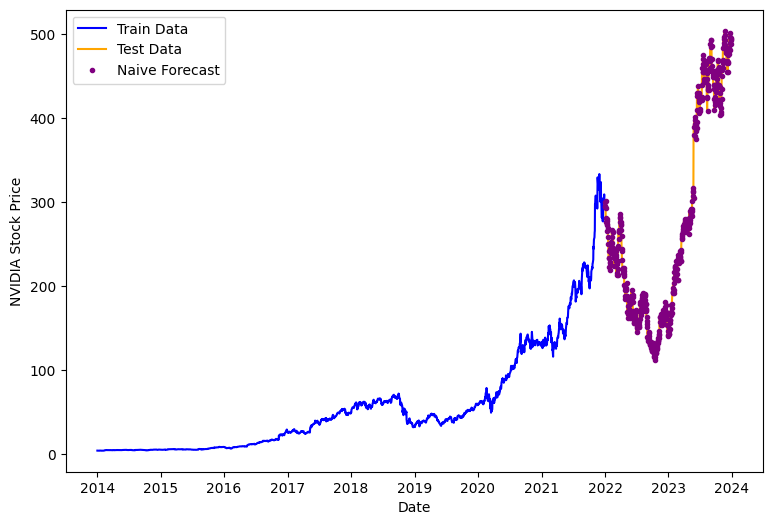

In [11]:
# Plotting
plt.figure(figsize=(9, 6))

# Plot training data
plt.plot(train_data.index, y_train, label='Train Data', color='blue')

# Plot testing data
plt.plot(test_data.index, y_test, label='Test Data', color='orange')

# Plot naive forecast - ensure to skip the first NaN value caused by the shift
plt.plot(test_data.index[1:], naive_forecast[1:], '.', label='Naive Forecast', color='purple')

plt.xlabel('Date')
plt.ylabel('NVIDIA Stock Price')
plt.legend()
plt.show()

The Naïve Forecast results show that the model is accurate enough to trust in making predictions, as Naïve model takes previous days data as today's data, and stock prices would'nt fluctuate heavily in a day's span, the model performs very well in predicting the stock price.

The forecast results confirm our assumptions from the plots, as the values that are returned are promising.

Resulting MAE, MSE and RMSE show that the deviation from the original data is average, it can be lower but as the scores go lower with more tuning, the model would become susceptible and sensitive to outliers.

MAPE(Mean Absolute Percentage Error) score denotes the percentage difference between the predicted and actual values.

These deviations in predictions can occur due to external factors that are difficult to address with hyperparamter tuning.

## Split Train and Test set

In [12]:
split_size = int(0.8*len(prices)) #80% train , 20% test

# Create Train Data Splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create Test Data Splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2012, 504, 2012, 504)

Time series data needs to be split in chronological order rather than the widely used random order. The benefits of splitting in chrological order are:


1.  **Preserves Temporal Order:**
    
    Time series data inherently has a temporal order, with data points collected at specific times. Splitting in series ensures the training data precedes the testing data chronologically. This is crucial because time series models often rely on past information to predict future values. Random splitting might disrupt this order, leading to unrealistic scenarios where the model is "trained on the future."
2.  **Captures Trends and Seasonality:**

    Time series data often exhibits trends (upward or downward movements) and seasonal patterns (e.g., daily, weekly, yearly cycles). Splitting in series ensures both training and testing data capture these patterns within their respective periods. This allows the model to learn from past trends and seasonality to make better predictions for future data points.
3.  **Improves Generalizability:**
    
    The goal is to build a model that can generalize well to unseen data. Splitting in series helps achieve this by exposing the model to a variety of trends and seasonality present throughout the data collection period. This ensures the model isn't just memorizing patterns specific to the training data.
4.  **Avoids Data Leakage:**

    Random splitting can lead to data leakage, where information from the testing data accidentally influences the training process. This can happen if, for example, a random split places a future trend or seasonal peak in the training data, giving the model an unfair advantage. Splitting in series avoids this issue.


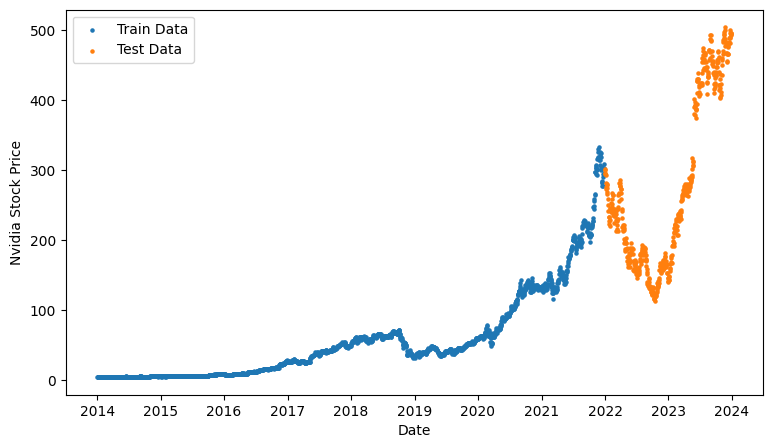

In [13]:
# Plot and check the Split to check for data leakage

plt.figure(figsize=(9,5))

plt.scatter(X_train, y_train, s=5, label='Train Data')

plt.scatter(X_test, y_test, s=5, label='Test Data')

plt.xlabel("Date")

plt.ylabel('Nvidia Stock Price')

plt.legend(fontsize=10)

plt.show()

We observe that there is no data leakage occuring after splitting the data, which means the data is ready to be used for modelling.

## Creating Functions, Horizons and Windows

In [14]:
# Visualize our train and test data.
def plot_time_series(timesteps, values,color, format=".", start=0, end= None, label=None):

  plt.plot(timesteps[start:end], values[start:end],format, label=label,color=color)
  plt.xlabel('Year')
  plt.ylabel('Nvidia Stock Prices')

  if label:
    plt.legend(fontsize=10)

plot_time_series function is used to visualise the fit of various models compared with actual data.

This function has been created so that we need not create a seperate visualising plot function for each created model and ease of use.

In [15]:
HORIZON = 1 # predicting price into the future- No of days
WINDOW_SIZE = 7 # how many days of past data used to predict future data.

From our learning with various prediction horizons, we have found that using data from the previous 7 days(1.5 week) is the best window size to be used.

In [16]:
def get_labelled_window(x, horizon=1):
    return x[:, :-horizon], x[:, -horizon:]

# Testing the window labelling function:
test_windows, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))

print(f"Window: {tf.squeeze(test_windows).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


get_labelled_window function prepares data for a sliding window approach.The first part of the returned tuple represents the input data (the window), and the second part represents the corresponding labels.

In [17]:
def make_windows(x, window_size=7, horizon=1):

  #Turns a 1D array into a 2D array of sequential windows of window_size.

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)

  return windows, labels

make_windows function is designed to transform a 1D array (or sequence) into a 2D array of sequential windows, where each window has a specified window_size and a horizon.

The function follows these steps:

*   **Create a window of specific size:**
    
    It first creates a window of size window_size + horizon. This step is done by generating an array containing values from 0 to window_size + horizon - 1. This array serves as the index of elements in the original sequence to form a single window. The horizon is added at the end for later labeling purposes.
    
*   **Create multiple window steps:**
    
    It then creates a 2D array of multiple window steps by adding the generated window index array to a range of indices from 0 to len(x) - (window_size + horizon - 1). This essentially creates multiple window starting points, each with a step size of 1.

*   **Index the target array:**
    
    It indexes the original 1D array x with the 2D array of multiple window steps. This results in a 3D array where each slice along the first axis represents a window of the original sequence.

*   **Get the labelled windows:**
    
    Finally, it uses the get_labelled_window function (defined above) to split each window into an input part (the window itself) and a label part (the next horizon elements after the window). It returns these windows and labels.

In [18]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2509, 2509)

In [19]:
# View the first 3 windows/labels where the next value is the first value of the other window
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [3.74054718 3.69573617 3.74526405 3.80658436 3.85847092 3.71460342
 3.70988607] -> Label: [3.62262344]
Window: [3.69573617 3.74526405 3.80658436 3.85847092 3.71460342 3.70988607
 3.62262344] -> Label: [3.73583055]
Window: [3.74526405 3.80658436 3.85847092 3.71460342 3.70988607 3.62262344
 3.73583055] -> Label: [3.77592421]


## Feature Scaling and Splitting into Train and Test sets

In [20]:
def make_train_test_splits(windows, labels, test_split=0.2, validation_split=0.1):
    # Splitting data into train and test initially
    split_size = int(len(windows) * (1 - test_split))  # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    test_windows = windows[split_size:]
    train_labels = labels[:split_size]
    test_labels = labels[split_size:]

    # Further split train data into train and validation sets
    validation_size = int(len(train_windows) * validation_split)  # 10% of the training set for validation
    val_windows = train_windows[-validation_size:]
    val_labels = train_labels[-validation_size:]

    # Update train data by removing validation data
    train_windows = train_windows[:-validation_size]
    train_labels = train_labels[:-validation_size]

    # Feature Scaling (fit only on training data)
    scaler = MinMaxScaler()
    train_windows_scaled = scaler.fit_transform(train_windows.reshape(-1, train_windows.shape[-1])).reshape(train_windows.shape)
    val_windows_scaled = scaler.transform(val_windows.reshape(-1, val_windows.shape[-1])).reshape(val_windows.shape)
    test_windows_scaled = scaler.transform(test_windows.reshape(-1, test_windows.shape[-1])).reshape(test_windows.shape)

    return train_windows_scaled, val_windows_scaled, test_windows_scaled, train_labels, val_labels, test_labels


'make_train_test_splits' function serves to split the dataset into training and testing sets after scaling the features. The process goes as follows:

*   **Feature Scaling:**
    
    It first scales the input windows using Min-Max scaling. This is a common preprocessing step for neural networks, ensuring that all features are on a similar scale, which can help improve convergence and performance, especially for algorithms sensitive to feature scales.

*   **Splitting Data:**
    
    It splits the scaled windows and their corresponding labels into training and testing sets. The default split ratio is 80% for training and 20% for testing. This means that 80% of the data will be used for training the model, and the remaining 20% will be used for evaluating its performance. The significance of this step lies in the importance of evaluating the model's generalization performance on unseen data, which is crucial for assessing how well it will perform on new, unseen examples in real-world scenarios.

*   **Return Values**:
    
    The function returns four sets of data: the scaled training windows, the scaled testing windows, the training labels, and the testing labels. These sets can then be used for training and evaluating machine learning models.

We also used a validation set which takes 10% of the training dataset to evaluate the best choice of hyperparamters to fit the model on.



In [21]:
(train_windows_scaled, test_windows_scaled, train_labels, test_labels, val_windows_scaled, val_labels) = make_train_test_splits(full_windows, full_labels)

len(train_windows_scaled), len(test_windows_scaled), len(train_labels), len(test_labels), len(val_windows_scaled), len(val_labels)

(1807, 200, 502, 1807, 200, 502)

These are the lengths of the training, testing and validation data sets.

These splits will be done for every model, as their size depends on the 'Window_size' used for predictions.

In [22]:
train_windows_scaled[:5], test_windows_scaled[:5], train_labels[:5], test_labels[:5], val_windows_scaled[:5], val_labels[:5]

(array([[0.0007897 , 0.00048961, 0.00082128, 0.00123193, 0.00157939,
         0.00061596, 0.00058437],
        [0.00048961, 0.00082128, 0.00123193, 0.00157939, 0.00061596,
         0.00058437, 0.        ],
        [0.00082128, 0.00123193, 0.00157939, 0.00061596, 0.00058437,
         0.        , 0.00075811],
        [0.00123193, 0.00157939, 0.00061596, 0.00058437, 0.        ,
         0.00075811, 0.0010266 ],
        [0.00157939, 0.00061596, 0.00058437, 0.        , 0.00075811,
         0.0010266 , 0.00110557]]),
 array([[0.8125443 , 0.80906885, 0.8441742 , 0.83498457, 0.85739117,
         0.86407476, 0.86741676],
        [0.80906885, 0.8441742 , 0.83498457, 0.85739117, 0.86407476,
         0.86741676, 0.8260618 ],
        [0.8441742 , 0.83498457, 0.85739117, 0.86407476, 0.86741676,
         0.8260618 , 0.83429944],
        [0.83498457, 0.85739117, 0.86407476, 0.86741676, 0.8260618 ,
         0.83429944, 0.85705703],
        [0.85739117, 0.86407476, 0.86741676, 0.8260618 , 0.83429944,
  

'train_labels' represent the target values to be predicted by the model based on the input features in the training window.

'test_labels' represent the values that the models predictions will be compared to.

In [23]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

This function encapsulates the process of using a trained model to make predictions on new input data and provides a convenient interface for generating predictions in a concise and reusable manner.

# Model Building

### DENSE model

In [24]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 7 # use 7 timesteps in the past

In [25]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2509, 2509)

In [26]:
# Make train and testing windows
train_windows_scaled, test_windows_scaled, val_windows_scaled, train_labels, test_labels, val_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows_scaled), len(test_windows_scaled), len(val_windows_scaled), len(train_labels), len(test_labels), len(val_labels)

(1807, 200, 502, 1807, 200, 502)

## Regularisation is used to prevent overfitting of the data by adding a penalty based on the absolute value of the weights.

### Building our first Deep learning model (Dense with Hyperparameter)

In [28]:
def create_model_1(hp):
    # Define hyperparameters
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    l1_reg = hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log')
    l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')

    # Construct model
    model = Sequential([
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)),
        layers.Dense(1, activation="linear")  # Dynamic output size
    ], name="model_1_dense")

    # Define optimizer (using only Adam optimizer)
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(loss="mae", optimizer=optimizer, metrics=["mae"])

    return model

'create_model' function is used to create a neural network model with hyperparamters that can be tuned using the Keras Tuner.

**Defining Hyperparameters**:

**units:** This hyperparameter determines the number of units (neurons) in the dense layer of the model. It is defined as an integer *ranging from 32 to 256* with a *step size of 32*. This range provides flexibility in the capacity of the model, allowing it to adapt to different complexities in the data.

**activation:** This hyperparameter specifies the activation function used in the dense layers of the model. The choices are '*relu*', '*tanh*', and '*elu*'. These activation functions provide different nonlinear transformations, allowing the model to learn complex patterns in the data.

**learning_rate:** This hyperparameter determines the learning rate of the Adam optimizer used for training the model. It is defined as a float *ranging from 1e^-4 to 1e^-2 on a logarithmic scale*.  

*   A logarithmic scale is often used for learning rates because it allows exploring a wide range of values while focusing on regions where significant improvements are likely to occur.

**Constructing Model:**

The model architecture consists of a single dense layer with the number of units specified by the units hyperparameter and activation function specified by the activation hyperparameter. The output layer has a *linear activation function*, which is suitable for regression tasks like predicting time series data.

**Defining Optimizer:**

The *Adam optimizer* is chosen for its effectiveness in training neural networks and its ability to adaptively adjust learning rates for each parameter. The learning rate of the optimizer is set based on the learning_rate hyperparameter defined earlier.

**Compiling Model:**

The model is compiled with *Mean Absolute Error (MAE)* as the loss function, which is suitable for regression tasks. The Adam optimizer and Mean Absolute Error metric are specified in the compilation step.



---
The following code block performs hyperparameter tuning for a neural network model using Keras Tuner, with early stopping to prevent overfitting. Let's break down what each part does and explain the reasoning behind the choices made:

**Early Stopping Callback:**

**early_stopping**:

  This callback monitors the validation loss (val_loss) and stops training if there is no improvement after a certain number of epochs (patience). It restores the best weights of the model when training is stopped. Early stopping helps prevent overfitting and saves computational resources by stopping training when the model's performance on the validation set no longer improves.

**Setting Random Seed:** **tf.random.set_seed(42):**
  
  This sets the random seed to 42 to ensure reproducibility of the results. Setting a random seed ensures that the same sequence of random numbers is generated each time the code is run, leading to reproducible results.

**Hyperparameter Tuning Configuration:** **Tuner**

  In this case, Hyperband is used as the tuner, which exhaustively searches through a predefined set of hyperparameters to find the combination that optimizes the specified objective function (val_loss in this case).

**Performing Hyperparameter Tuning: tuner.search:**

  This method starts the hyperparameter search process. It trains and evaluates models with different hyperparameter combinations using the provided training and validation data. Early stopping callback is passed to prevent overfitting during tuning.

**Fitting the Best Model: best_model.fit**

  This fits the best model to the training data. Early stopping callback is also passed here.

### Searching best parameters and fitting the model

In [29]:
# Set seed for reproducibility
tf.random.set_seed(42)

# Create the Hyperband tuner
tuner = Hyperband(
    create_model_1,
    objective="val_loss",
    max_epochs=70,  # Maximum number of epochs to train one model
    factor=3,        # Reduction factor for the number of epochs and number of models in each bracket
    executions_per_trial=3,  # How many times each model configuration will be run
    directory='hyperparameter_tuning',
    project_name='hyperband_tuning_model_1'
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Perform the hyperparameter search
tuner.search(
    train_windows_scaled,
    train_labels,
    epochs=70,
    validation_data=(val_windows_scaled, val_labels),
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model_1 = tuner.hypermodel.build(best_hps)

# Fit the best model
best_model_1.fit(
    train_windows_scaled,
    train_labels,
    epochs=200,
    batch_size=128,
    validation_data=(val_windows_scaled, val_labels),
    callbacks=[early_stopping]
)

# Save the best model
best_model_1.save("/content/hyperparameter_tuning/hyperband_tuning_model_1/best_model_1.keras")

## Loading the Model and evaluating it with Test data (Unseen)

In [30]:
# Load the best model
best_model_path = "/content/hyperparameter_tuning/hyperband_tuning_model_1/best_model_1.keras"
best_model = tf.keras.models.load_model(best_model_path)

# Evaluate the loaded model on the test data
evaluation_result = best_model.evaluate(test_windows_scaled, test_labels)
print("Evaluation result (loss, metrics):", evaluation_result)

7/7 [==============================] - 1s 12ms/step - loss: 4.8765 - mae: 4.8633
Evaluation result (loss, metrics): [4.876500129699707, 4.8632917404174805]


After fitting the models with random hyperparameter values and finding the best fit, the results are shown to be compared with basline and other models.

In [31]:
model_1_preds = make_preds(best_model, input_data=test_windows_scaled)

7/7 [==============================] - 0s 3ms/step


In [32]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'MAE': 4.8632917, 'MSE': 46.90715, 'RMSE': 6.8488793, 'MAPE': 2.2228727}

## Evaluating the comparisons using a dataframe

In [33]:
naive_df = pd.DataFrame(naive_results, index=['Naive Forecast'])
model_1_df = pd.DataFrame(model_1_results, index=['Model 1 Forecast(Dense 1 model)'])

# Concatenate both DataFrames
comparison_df = pd.concat([naive_df, model_1_df])

# Print the comparison
print("Forecast Evaluation Comparison:")
print(comparison_df)

Forecast Evaluation Comparison:
                                      MAE        MSE      RMSE      MAPE
Naive Forecast                   6.646405  81.330208  9.018326  2.648675
Model 1 Forecast(Dense 1 model)  4.863292  46.907150  6.848879  2.222873


## Graph of Model 1(Dense).

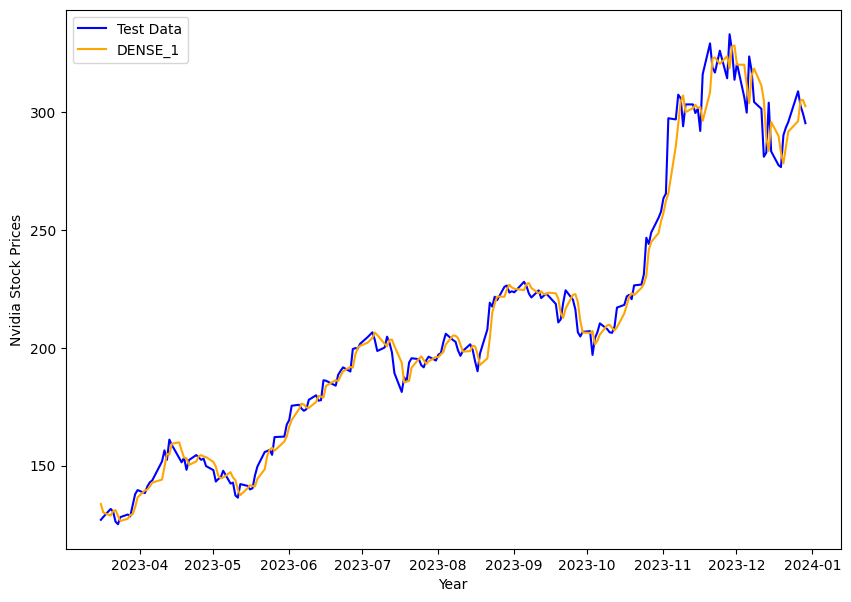

In [ ]:
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values= test_labels[:, 0],label='Test Data',format="-", color='blue')


plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values= model_1_preds, format="-", label='DENSE_1', color='Orange')

The price predictions of DENSE model are then visualised to have a visual comparison of how the model performed against the actual stock price.

## Comparing Naive Forecast and Dense_1 using bar graph

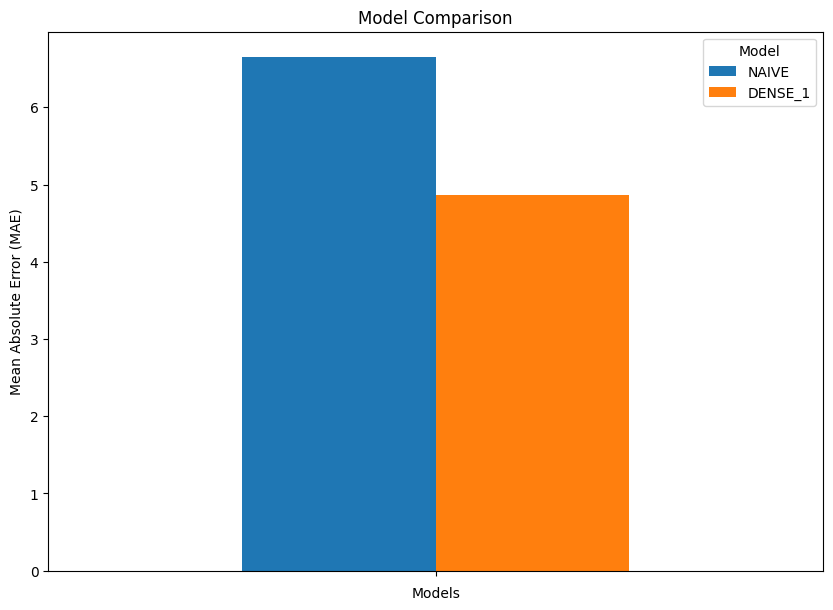

In [34]:
df = pd.DataFrame({"NAIVE": naive_results["MAE"],
                   "DENSE_1": model_1_results["MAE"]},
                  index=[""])

ax = df.plot(figsize=(10, 7), kind="bar")
ax.set_xlabel("Models")
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("Model Comparison")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Model");

We can infer from this comparison that the Naive Forecast outperforms Dense Model, which is expected as Naïve is a simple model and DENSE is computationally heavy.

DENSE model has performed well with a respectable MAE score for the given WINDOW and HORIZON size.

### DENSE - Window and Horizon size experimentation

In [35]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 60 # use 60 timesteps in the past

DENSE_1 used window_size (data points in the past used for training) of 7 to predict price in Horizon (price in future) of 1.

This time the window_size is being increased to 60 to check if increasing the training size increases the accuracy of predictions.

In [36]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2456, 2456)

In [37]:
# Make train and testing windows
train_windows_scaled, test_windows_scaled, val_windows_scaled, train_labels, test_labels, val_labels = make_train_test_splits(windows=full_windows, labels=full_labels,test_split=0.2)
len(train_windows_scaled), len(test_windows_scaled), len(val_windows_scaled), len(train_labels), len(test_labels), len(val_labels)

(1768, 196, 492, 1768, 196, 492)



---

**Define Hyperparameters:**

**units:** The number of neurons is given as a choice among [32, 64, 128, 256]. These values provide a range of options for the model's capacity, allowing it to adapt to different complexities in the data.

**learning_rate:** This hyperparameter determines the learning rate of the Adam optimizer used for training the model.
It is defined as a choice among [1e-4, 1e-3, 1e-2]. These values cover a range of magnitudes for the learning rate, allowing the model to explore different learning rates during training.

DENSE_1 had set **units** value as 32 and **learning_rate** ranged from 1e-4 to 1e-2 on a logarithmic scale.

### L1 and L2 also known as Lasso and Ridge regularisation is used to prevent overfitting of the data by adding a penalty based on the absolute value of the weights.

In [38]:
def create_model_2(hp):
    # Define hyperparameters
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    l1 = hp.Float('l1_reg', min_value=1e-5, max_value=1e-2, sampling='log')
    l2 = hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')

    # Construct model
    model = tf.keras.Sequential([
        layers.Dense(units, activation=activation, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)),
        layers.Dense(HORIZON, activation="linear")
    ], name="model_2")

    # Define optimizer (using only Adam optimizer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(loss="mae", optimizer=optimizer, metrics=["mae"])

    return model

## Searching best parameters and fitting the model

In [ ]:
# Set seed for reproducibility
tf.random.set_seed(42)

# Create the Hyperband tuner
tuner = Hyperband(
    create_model_2,
    objective="val_loss",
    max_epochs=70,  # Maximum number of epochs to train one model
    factor=3,        # Reduction factor for the number of epochs and number of models in each bracket
    executions_per_trial=3,  # How many times each model configuration will be run
    directory='hyperparameter_tuning',
    project_name='hyperband_tuning_model_2'
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Perform the hyperparameter search
tuner.search(
    train_windows_scaled,
    train_labels,
    epochs=70,
    validation_data=(val_windows_scaled, val_labels),
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model_2 = tuner.hypermodel.build(best_hps)

# Fit the best model
best_model_2.fit(
    train_windows_scaled,
    train_labels,
    epochs=200,
    batch_size=128,
    validation_data=(val_windows_scaled, val_labels),
    callbacks=[early_stopping]
)

# Save the best model
best_model_2.save("/content/hyperparameter_tuning/hyperband_tuning_model_2/best_model_2.keras")

## Loading the Model and evaluating it with Test data (Unseen)

In [39]:
best_model_2_path = "/content/hyperparameter_tuning/hyperband_tuning_model_2/best_model_2.keras"
best_model_2 = tf.keras.models.load_model(best_model_2_path)

# Evaluate the loaded model on the test data
evaluation_result = best_model_2.evaluate(test_windows_scaled, test_labels)
print("Evaluation result (loss, metrics):", evaluation_result)

7/7 [==============================] - 0s 3ms/step - loss: 6.1458 - mae: 5.7408
Evaluation result (loss, metrics): [6.145797252655029, 5.740809440612793]


In [41]:
model_2_preds = make_preds(best_model_2, input_data=test_windows_scaled)

7/7 [==============================] - 0s 2ms/step


In [42]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'MAE': 5.7408094, 'MSE': 62.735096, 'RMSE': 7.920549, 'MAPE': 2.5384583}

### Comparing models using a Dataframe

In [43]:
naive_df = pd.DataFrame(naive_results, index=['Naive Forecast'])
model_1_df = pd.DataFrame(model_1_results, index=['Model 1 Forecast'])
model_2_df = pd.DataFrame(model_2_results, index=['Model 2 Forecast'])

# Concatenate both DataFrames
comparison_df = pd.concat([naive_df, model_1_df, model_2_df])

# Print the comparison
print("Forecast Evaluation Comparison:")
print(comparison_df)

Forecast Evaluation Comparison:
                       MAE        MSE      RMSE      MAPE
Naive Forecast    6.646405  81.330208  9.018326  2.648675
Model 1 Forecast  4.863292  46.907150  6.848879  2.222873
Model 2 Forecast  5.740809  62.735096  7.920549  2.538458


## Visualizing the Model

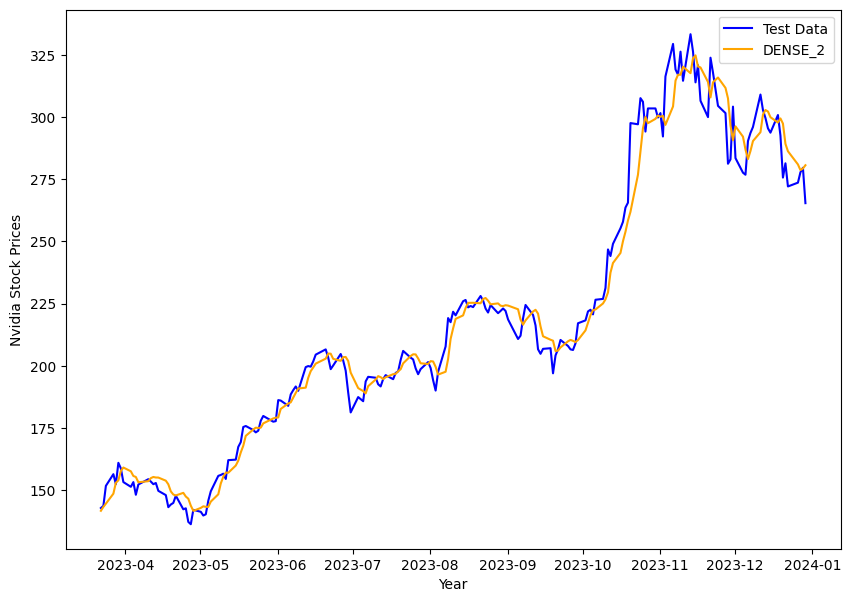

In [ ]:
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values= test_labels[:, 0],label='Test Data',format="-", color='blue')

plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values= model_2_preds, format="-", label='DENSE_2', color='Orange')

## Comparing the models

Comparing the baseline with the two DENSE models by visualising their MAE scores.

Lower MAE is better.

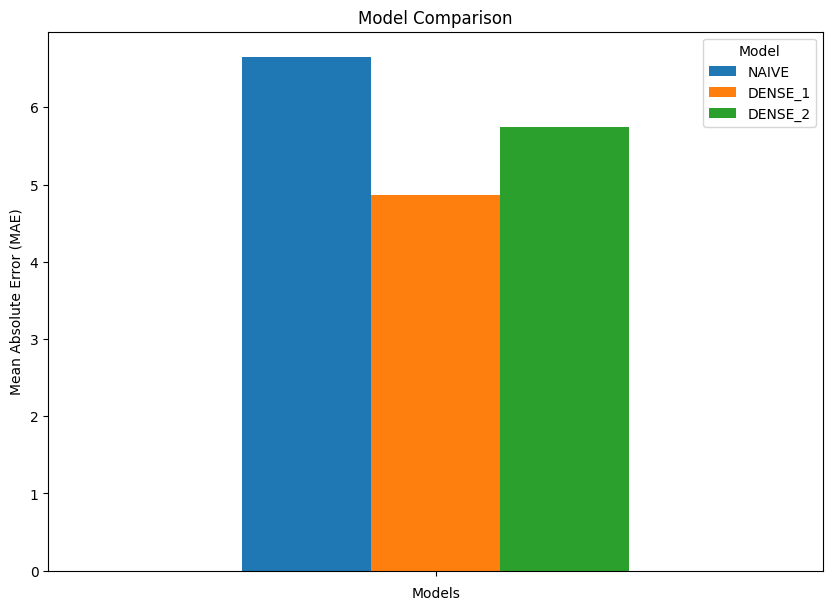

In [ ]:
df = pd.DataFrame({"NAIVE": naive_results["MAE"],
                   "DENSE_1": model_1_results["MAE"],
                   "DENSE_2": model_2_results["MAE"]},
                  index=[""])

ax = df.plot(figsize=(10, 7), kind="bar")
ax.set_xlabel("Models")
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("Model Comparison")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Model");

From the results of DENSE_2 we can conclude that using a larger training window size results in an increase in Mean Absolute Error (MAE) value, which means the model is worse than the model which uses 7 day training window size.

This can be due to the model having maore data to process and overfitting as a side-effect.

## 1 Dimensional CNN

For our third model, we have used 1D CNN.

1D CNN offers several benefits compared to DENSE, thay are:

**Capturing Local Patterns:**

  Convolutional operations in CNNs scan the input data with a sliding window, allowing the model to detect and learn from local patterns such as trends, seasonality, and short-term fluctuations without the need for manual feature engineering. Dense layers, on the other hand, treat the input data as a flat vector, making them less effective at capturing local patterns in sequential data.

**Parameter Efficiency:**

  1D CNNs can be more parameter-efficient than dense layers. Convolutional operations in CNNs share weights across different regions of the input data, leading to fewer parameters compared to densely connected layers. This parameter efficiency can result in faster training times, reduced memory consumption, and better generalization performance, especially on large datasets.

In [44]:
HORIZON = 1
WINDOW_SIZE = 7

In [45]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2509, 2509)

In [46]:
# Make train and testing windows
train_windows_scaled, test_windows_scaled, val_windows_scaled, train_labels, test_labels, val_labels = make_train_test_splits(windows=full_windows, labels=full_labels,test_split=0.2)
len(train_windows_scaled), len(test_windows_scaled), len(val_windows_scaled), len(train_labels), len(test_labels), len(val_labels)

(1807, 200, 502, 1807, 200, 502)

In [47]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows_scaled[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[0.0007897 ]
 [0.00048961]
 [0.00082128]
 [0.00123193]
 [0.00157939]
 [0.00061596]
 [0.00058437]]


'build_model' function is responsible for constructing a convolutional neural network (CNN) model with hyperparameters that can be tuned using the Keras Tuner.

**Input Data Preparation: layers.Lambda(lambda x: tf.expand_dims(x, axis=1))**
  
  This lambda layer is added to expand the dimensions of the input data. Since Conv1D layers in Keras expect inputs with shape (batch_size, sequence_length, input_dim), this lambda layer adds a new dimension at axis 1 to represent the sequence length, making the input shape compatible with Conv1D layers.

**Convolutional Layer: layers.Conv1D:**

  This layer applies one-dimensional convolution to the input data. The hyperparameters are:
  
*    **filters:** The number of filters (output channels) in the convolutional layer. This hyperparameter is chosen to be tunable with a range from 32 to 256 with a step size of 32, allowing the model's capacity to be adjusted during hyperparameter tuning.
*   **kernel_size:** The size of the convolutional kernel. The hyperparameter is chosen as a choice among [3, 5, 7], representing different receptive field sizes for capturing patterns in the input sequence.
*   **padding:** The padding mode for the convolutional operation. "causal" padding ensures that the output at time step t only depends on the inputs at time steps up to t, which is important for time series data.
*   **activation:** The activation function applied to the output of the convolutional layer. "relu" (Rectified Linear Unit) activation function is commonly used in CNNs for introducing non-linearity.
  

**Output Layer:  layers.Dense(HORIZON):**

  This dense layer with HORIZON units is added as the output layer of the model. Since the task is likely a time series prediction task where the model predicts a sequence of future values (horizon), a dense layer with the same number of units as the horizon is added to output the predicted values.

**Compilation:  model.compile:**

  The model is compiled with Mean Absolute Error (MAE) as the loss function and Adam optimizer. MAE is a common choice for regression tasks, and Adam optimizer is widely used for training neural networks due to its effectiveness and adaptive learning rate.



---
**Creating the Tuner:**

**tuner:** This initializes a RandomSearch tuner. Random search is a hyperparameter optimization technique that randomly samples hyperparameters from the search space. The tuner takes the build_model function (which constructs the model with tunable hyperparameters) as input, along with the objective to minimize (val_loss), the maximum number of trials (max_trials), and the directory to save the results.

**Performing Hyperparameter Tuning:**

**tuner.search:** This method starts the hyperparameter search process. It trains and evaluates models with different hyperparameter combinations using the provided training and validation data. Early stopping callback is passed to prevent overfitting during tuning.

Regularisation is used to prevent overfitting of the data by adding a penalty based on the absolute value of the weights.

In [48]:
def build_model_conv1D(hp):
    model = Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),  # Ensure input is correctly shaped
        layers.Conv1D(
            filters=hp.Int('filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
            padding="causal",
            activation="relu",
            kernel_regularizer=regularizers.l1_l2(
                l1=hp.Float('l1', min_value=1e-5, max_value=1e-2, sampling='log'),
                l2=hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='log')
            )
        ),
        layers.Dense(1)
    ])
    model.compile(
        loss="mae",
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    )
    return model

In [ ]:
# Set seed for reproducibility
tf.random.set_seed(42)

# Create the Hyperband tuner
tuner = Hyperband(
    build_model_conv1D,
    objective="val_loss",
    max_epochs=70,  # Maximum number of epochs to train one model
    factor=3,        # Reduction factor for the number of epochs and number of models in each bracket
    executions_per_trial=3,  # How many times each model configuration will be run
    directory='hyperparameter_tuning',
    project_name='hyperband_tuning_CONV1D'
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Perform the hyperparameter search
tuner.search(
    train_windows_scaled,
    train_labels,
    epochs=70,
    validation_data=(val_windows_scaled, val_labels),
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model_3 = tuner.hypermodel.build(best_hps)

# Fit the best model
best_model_3.fit(
    train_windows_scaled,
    train_labels,
    epochs=200,
    batch_size=128,
    validation_data=(val_windows_scaled, val_labels),
    callbacks=[early_stopping]
)

# Save the best model
best_model_3.save("/content/hyperparameter_tuning/hyperband_tuning_CONV1D/best_model_3.keras")

In [49]:
best_model_3_path = "/content/hyperparameter_tuning/hyperband_tuning_CONV1D/best_model_3.keras"
best_model_3 = tf.keras.models.load_model(best_model_3_path, safe_mode=False)

# Evaluate the loaded model on the test data
evaluation_result = best_model_3.evaluate(test_windows_scaled, test_labels)
print("Evaluation result (loss, metrics):", evaluation_result)

7/7 [==============================] - 1s 14ms/step - loss: 8.6460
Evaluation result (loss, metrics): 8.646010398864746


Using the test set to make predictions based on the best fitted mdoel.

In [51]:
model_3_preds = make_preds(best_model_3, input_data=test_windows_scaled)

7/7 [==============================] - 0s 2ms/step


Results of the fitted test set.

In [52]:
# Make predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'MAE': 7.503096, 'MSE': 104.64907, 'RMSE': 10.229813, 'MAPE': 3.478753}

Results are printed for the model that best fit.

In [ ]:
naive_df = pd.DataFrame(naive_results, index=['Naive Forecast'])
model_1_df = pd.DataFrame(model_1_results, index=['Model 1 Forecast(Dense 1)'])
model_2_df = pd.DataFrame(model_2_results, index=['Model 2 Forecast(Dense 2)'])
model_3_df = pd.DataFrame(model_3_results, index=['Model 3 Forecast (1D CNN)'])

# Concatenate both DataFrames
comparison_df = pd.concat([naive_df, model_1_df, model_2_df, model_3_df])

# Print the comparison
print("Forecast Evaluation Comparison:")
print(comparison_df)

Forecast Evaluation Comparison:
                                MAE         MSE       RMSE      MAPE
Naive Forecast             6.646403   81.330200   9.018326  2.648674
Model 1 Forecast(Dense 1)  4.863292   46.907124   6.848877  2.222873
Model 2 Forecast(Dense 2)  5.740806   62.735092   7.920549  2.538457
Model 3 Forecast (1D CNN)  7.503093  104.649040  10.229812  3.478752


The results of the best fit are then compared to the best fit results of the previous models and the baseline for us to compare.

(Note: Lower is better is every testing metric)

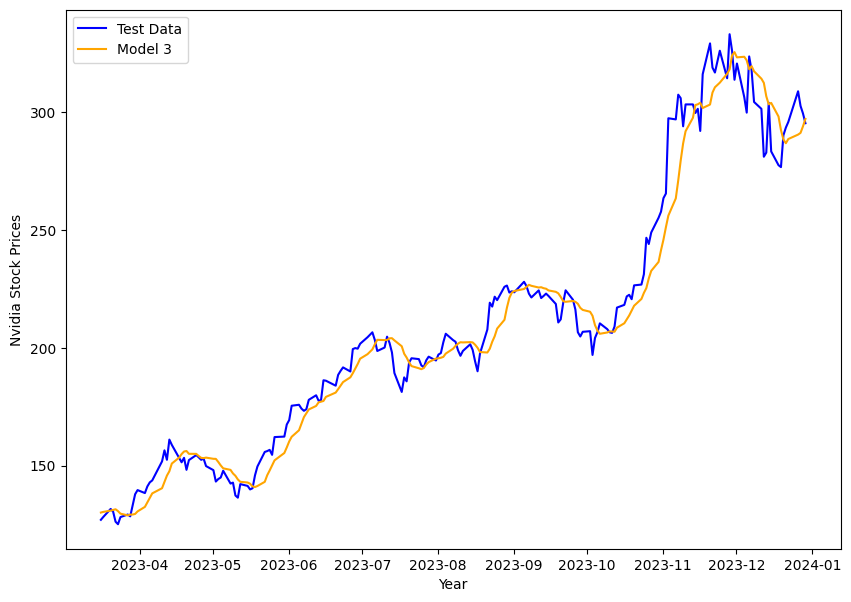

In [ ]:
plt.figure(figsize=(10,7))

# Plot the test data
plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values=test_labels[:, 0],  label='Test Data', format="-", color='blue')

# Plot the mean of the Conv1D model's predictions
# Calculate the mean of the 7 prediction values across the second dimension using TensorFlow's reduce_mean
model_3_mean_preds = tf.reduce_mean(model_3_preds, axis=1)

plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values=model_3_mean_preds,  format="-", label='Model 3', color='orange')

plt.legend()
plt.show()

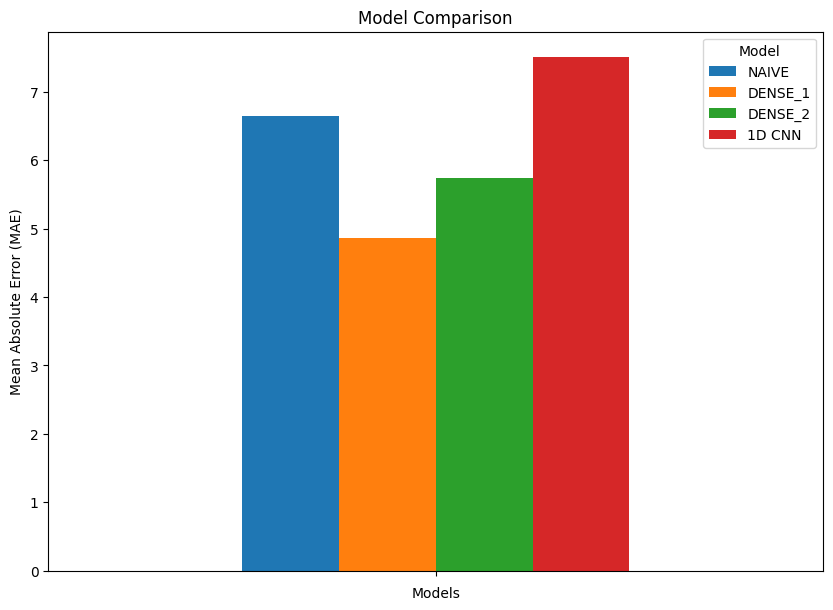

In [ ]:
df = pd.DataFrame({"NAIVE": naive_results["MAE"],
                   "DENSE_1": model_1_results["MAE"],
                   "DENSE_2": model_2_results["MAE"],
                   "1D CNN": model_3_results["MAE"]},
                  index=[""])

ax = df.plot(figsize=(10, 7), kind="bar")
ax.set_xlabel("Models")
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("Model Comparison")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Model");

From this MAE comparison of the model created until now, we can conclude that the 1D-CNN model has the highest score, this could be due to the complexity of 1D-CNN  models.

The most probable reason for the 1D-CNN model to be worse off is due to the volatility of the stock prices as they are more sensitive to noisy data. DENSE models would be more robust at handling noisy data.

## Long Short-Term Memory (LSTM) - RNN

We are continuing with a window-size of 7 as it has proven to be a sufficient training window, and prevents the model from overfitting.

In [54]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [55]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2509, 2509)

In [56]:
# Make train and testing windows
train_windows_scaled, test_windows_scaled, val_windows_scaled, train_labels, test_labels, val_labels = make_train_test_splits(windows=full_windows, labels=full_labels,test_split=0.2)
len(train_windows_scaled), len(test_windows_scaled), len(val_windows_scaled), len(train_labels), len(test_labels), len(val_labels)

(1807, 200, 502, 1807, 200, 502)

Regularisation is used to prevent overfitting of the data by adding a penalty based on the absolute value of the weights.

In [57]:
# Define a function to build your model with hyperparameters
def build_model_LSTM(hp):
    # Define hyperparameters
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # L1 and L2 regularization terms are used to prevent overfitting
    l1_value = hp.Float('l1', min_value=0.0001, max_value=0.01, sampling='log')  # Adjusted min and max values
    l2_value = hp.Float('l2', min_value=0.0001, max_value=0.01, sampling='log')  # Adjusted min and max values
    clip_value = hp.Float('clip_norm', min_value=0.1, max_value=1.0, step=0.1)

    # Define input layer
    inputs = tf.keras.Input(shape=(WINDOW_SIZE,))

    # Expand dimensions to match LSTM input requirement
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM

    # Define LSTM layer
    x = layers.LSTM(
        units=units,
        activation='relu',
        return_sequences=False,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_value, l2=l2_value)
    )(x)

    # Output layer
    outputs = layers.Dense(HORIZON)(x)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile model with gradient clipping
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        clipnorm=clip_value
    )
    model.compile(
        loss="mae",
        optimizer=optimizer
    )
    return model

In [ ]:
# Set seed for reproducibility
tf.random.set_seed(42)

# Create the Hyperband tuner
tuner = Hyperband(
    build_model_LSTM,
    objective="val_loss",
    max_epochs=70,  # Maximum number of epochs to train one model
    factor=3,        # Reduction factor for the number of epochs and number of models in each bracket
    executions_per_trial=3,  # How many times each model configuration will be run
    directory='hyperparameter_tuning',
    project_name='hyperband_tuning_model_LSTM'
)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Perform the hyperparameter search
tuner.search(
    train_windows_scaled,
    train_labels,
    epochs=70,
    validation_data=(val_windows_scaled, val_labels),
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model_LSTM = tuner.hypermodel.build(best_hps)

# Fit the best model
best_model_LSTM.fit(
    train_windows_scaled,
    train_labels,
    epochs=300,
    batch_size=128,
    validation_data=(val_windows_scaled, val_labels),
    callbacks=[early_stopping]
)


# Save the best model
best_model_LSTM.save("/content/hyperparameter_tuning/hyperband_tuning_model_LSTM/best_model_LSTM.keras")

In [58]:
best_model_LSTM_path = "/content/hyperparameter_tuning/hyperband_tuning_model_LSTM/best_model_LSTM.keras"
best_model_LSTM = tf.keras.models.load_model(best_model_LSTM_path, safe_mode=False)

# Evaluate the loaded model on the test data
evaluation_result = best_model_LSTM.evaluate(test_windows_scaled, test_labels)
print("Evaluation result (loss, metrics):", evaluation_result)

7/7 [==============================] - 1s 11ms/step - loss: 5.1946
Evaluation result (loss, metrics): 5.194583892822266


In [59]:
model_LSTM_preds = make_preds(best_model_LSTM, input_data=test_windows_scaled)

7/7 [==============================] - 0s 6ms/step


In [60]:
# Make predictions
model_LSTM_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_LSTM_preds)
model_LSTM_results

{'MAE': 4.955575, 'MSE': 48.60064, 'RMSE': 6.9714155, 'MAPE': 2.2648475}

In [61]:
naive_df = pd.DataFrame(naive_results, index=['Naive Forecast'])
model_1_df = pd.DataFrame(model_1_results, index=['Model 1 Forecast(Dense 1)'])
model_2_df = pd.DataFrame(model_2_results, index=['Model 2 Forecast(Dense 2)'])
model_3_df = pd.DataFrame(model_3_results, index=['Model 3 Forecast (1D CNN)'])
model_LSTM_df = pd.DataFrame(model_LSTM_results, index=['LSTM Model Forecast'])

# Concatenate both DataFrames
comparison_df = pd.concat([naive_df, model_1_df, model_2_df, model_3_df, model_LSTM_df])

# Print the comparison
print("Forecast Evaluation Comparison:")
print(comparison_df)

Forecast Evaluation Comparison:
                                MAE         MSE       RMSE      MAPE
Naive Forecast             6.646405   81.330208   9.018326  2.648675
Model 1 Forecast(Dense 1)  4.863292   46.907150   6.848879  2.222873
Model 2 Forecast(Dense 2)  5.740809   62.735096   7.920549  2.538458
Model 3 Forecast (1D CNN)  7.503096  104.649071  10.229813  3.478753
LSTM Model Forecast        4.955575   48.600639   6.971416  2.264848


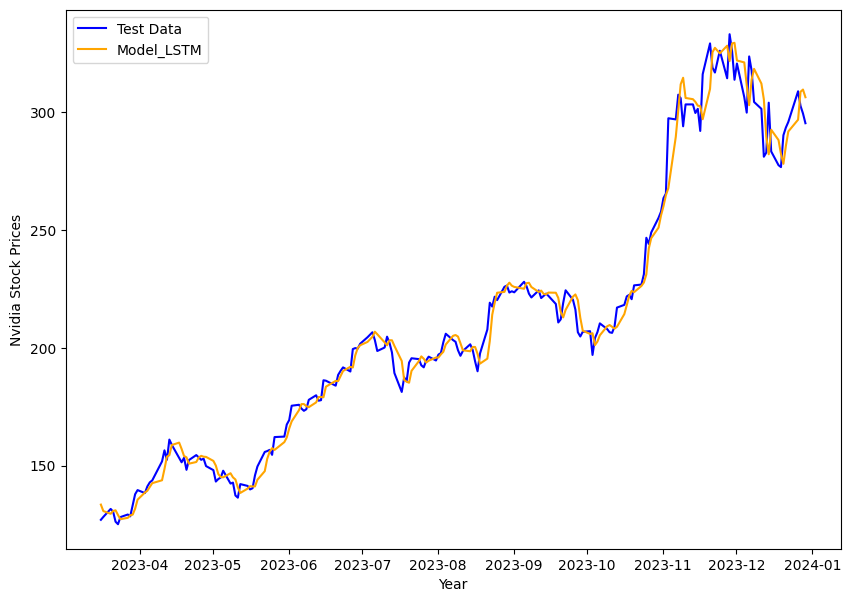

In [ ]:
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values= test_labels[:, 0],label='Test Data',format="-", color='blue')

plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values= model_LSTM_preds, format="-", label='Model_LSTM', color='Orange')

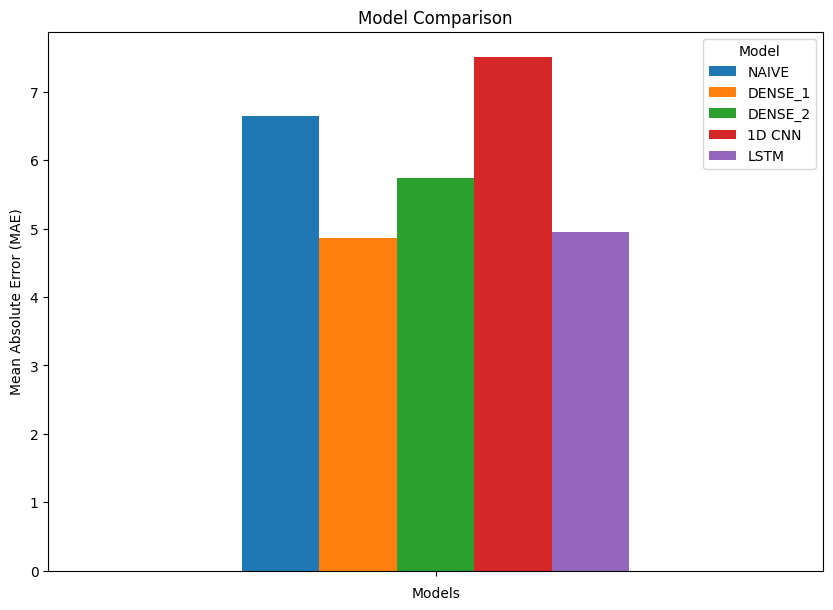

In [ ]:
df = pd.DataFrame({"NAIVE": naive_results["MAE"],
                   "DENSE_1": model_1_results["MAE"],
                   "DENSE_2": model_2_results["MAE"],
                   "1D CNN": model_3_results["MAE"],
                   "LSTM": model_LSTM_results["MAE"]},
                  index=[""])

ax = df.plot(figsize=(10, 7), kind="bar")
ax.set_xlabel("Models")
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("Model Comparison")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Model")

## Final Evaluation on Model Performance

Based on the comprehensive evaluation of various forecasting models for stock price prediction, it is evident that LSTM (Long Short-Term Memory) outperforms the other models in terms of multiple evaluation metrics. The comparison reveals that the LSTM model achieves the lowest Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) among all the models assessed.

Dense models, being simpler, performs sligtly better than our LSTM model, since we have a smaller dataset at hand and primarly due to their effectiveness in capturing patterns easily in smaller datasets. This advantage stems from the volatility present in the data, which the dense models handle more efficiently.

On the other hand, LSTM models, being more complex, excel in capturing longer temporal patterns within the data. Despite their robustness in this regard, they may not perform as well as dense models when dealing with smaller datasets and shorter-term patterns.

Therefore, based on these results, it can be concluded that the LSTM model exhibits superior predictive accuracy and reliability compared to alternative approaches such as naive forecasting, dense neural networks (Model 1 and Model 2), and a 1D convolutional neural network (Model 3). Consequently, the LSTM model stands as the preferred choice for stock price prediction tasks due to its ability to capture complex temporal dependencies in the data, leading to more accurate forecasts.


These findings provide valuable insights for stakeholders and practitioners in the financial domain, highlighting the efficacy of LSTM models in enhancing forecasting performance and decision-making processes.

---

# ----End of Project----

# Ensemble method

### The ensemble method is included here. Ensemble methods are used in different modelling competitions. It combines the power of multiple models to make decision and often outperform standalone models, making them a preferred approach in many cases.

### However, despite its effectiveness, implementing ensemble methods can pose challenges, especially in computational resource-intensive environments. In our case, constraints such as Colab crashes or timeouts have hindered our ability to execute the ensemble method immediately.

### Inspite of these limitations, we recognize the potential benefits of incorporating ensemble methods and aim to explore them further in the future.

### Below is our working code:

In [ ]:
"""HORIZON = 1 # predicting price into the future- No of days
WINDOW_SIZE = 7 # how many days of past data used to predict future data."""

In [ ]:
"""# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)"""

In [ ]:
"""# Make train and testing windows
train_windows_scaled, test_windows_scaled, val_windows_scaled, train_labels, test_labels, val_labels = make_train_test_splits(windows=full_windows, labels=full_labels,test_split=0.2)
len(train_windows_scaled), len(test_windows_scaled), len(val_windows_scaled), len(train_labels), len(test_labels), len(val_labels)"""

In [ ]:
"""# Ensure all labels are reshaped to (-1, 1) if they aren't already. This is necessary for consistency across training, validation, and testing.
train_windows_scaled = train_windows_scaled.reshape(-1, WINDOW_SIZE, 1)  # Add an extra dimension for features
val_windows_scaled = val_windows_scaled.reshape(-1, WINDOW_SIZE, 1)  # Do the same for validation data
test_windows_scaled = test_windows_scaled.reshape(-1, WINDOW_SIZE, 1)  # And for test data
"""

### Converting our data to Tensors

In [ ]:
"""# Convert scaled and split data into TensorFlow datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(train_windows_scaled)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

val_features_dataset = tf.data.Dataset.from_tensor_slices(val_windows_scaled)
val_labels_dataset = tf.data.Dataset.from_tensor_slices(val_labels)

test_features_dataset = tf.data.Dataset.from_tensor_slices(test_windows_scaled)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)"""

In [ ]:
"""# Zip features and labels to create complete datasets
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
val_dataset = tf.data.Dataset.zip((val_features_dataset, val_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))"""

In [ ]:
"""# Batch and prefetch for optimal performance
BATCH_SIZE = 128  # Adjust batch size according to your model and memory capacity
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)"""

In [ ]:
"""# Output the datasets to check
train_dataset, val_dataset, test_dataset"""

# Model Definition

In [ ]:
"""def build_ensemble_models(hp):
    model_type = hp.Choice('model_type', ['dense', 'lstm', 'cnn'])

    if model_type == 'dense':
        model = tf.keras.Sequential([
            layers.Dense(units=hp.Int('units1', min_value=64, max_value=256, step=32),
                         activation='relu', kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l1_l2(
                             l1=hp.Float('l1_1', min_value=1e-5, max_value=1e-2, sampling='log'),
                             l2=hp.Float('l2_1', min_value=1e-5, max_value=1e-2, sampling='log')
                         )),
            layers.BatchNormalization(),
            layers.Dense(units=hp.Int('units2', min_value=64, max_value=256, step=32),
                         activation='relu', kernel_initializer='he_normal',
                         kernel_regularizer=regularizers.l1_l2(
                             l1=hp.Float('l1_2', min_value=1e-5, max_value=1e-2, sampling='log'),
                             l2=hp.Float('l2_2', min_value=1e-5, max_value=1e-2, sampling='log')
                         )),
            layers.BatchNormalization(),
            layers.Dense(HORIZON, kernel_initializer='he_normal')
        ])
    elif model_type == 'lstm':
        model = tf.keras.Sequential([
            layers.LSTM(units=hp.Int('lstm_units1', min_value=64, max_value=256, step=32), return_sequences=True,
                        kernel_regularizer=regularizers.l1_l2(
                            l1=hp.Float('l1_lstm_1', min_value=1e-5, max_value=1e-2, sampling='log'),
                            l2=hp.Float('l2_lstm_1', min_value=1e-5, max_value=1e-2, sampling='log')
                        ), kernel_initializer='he_normal'),
            layers.Dropout(0.2),
            layers.LSTM(units=hp.Int('lstm_units2', min_value=64, max_value=256, step=32),
                        kernel_regularizer=regularizers.l1_l2(
                            l1=hp.Float('l1_lstm_2', min_value=1e-5, max_value=1e-2, sampling='log'),
                            l2=hp.Float('l2_lstm_2', min_value=1e-5, max_value=1e-2, sampling='log')
                        ), kernel_initializer='he_normal'),
            layers.Dropout(0.2),
            layers.Dense(HORIZON)
        ])
    elif model_type == 'cnn':
        model = tf.keras.Sequential([
            layers.Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32), kernel_size=3, activation='relu',
                          kernel_regularizer=regularizers.l1_l2(
                              l1=hp.Float('l1_cnn', min_value=1e-5, max_value=1e-2, sampling='log'),
                              l2=hp.Float('l2_cnn', min_value=1e-5, max_value=1e-2, sampling='log')
                          ), kernel_initializer='he_normal'),
            layers.MaxPooling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(HORIZON)
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss=hp.Choice('loss', values=['mae', 'mse', 'mape']),
        metrics=['mae', 'mse']
    )
    return model
"""

## Tuner

In [ ]:
"""def create_ensemble_models(num_models=5, train_data=train_dataset, val_data=val_dataset):
    ensemble_models = []
    for i in range(num_models):
        tuner = Hyperband(
            build_ensemble_models,
            objective="val_loss",
            max_epochs=50,
            factor=3,
            executions_per_trial=3,
            directory='hyperparameter_tuning',
            project_name='hyperband_tuning_model_ensemble',
            overwrite=True
        )

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        tuner.search(
            train_data,
            epochs=50,
            validation_data=val_data,
            callbacks=[early_stopping]
        )

        best_model = tuner.get_best_models(num_models=1)[0]

        best_model.fit(
            train_data,
            epochs=200,
            validation_data=val_data,
            callbacks=[early_stopping]
        )

        model_path = "/content/hyperparameter_tuning/hyperband_tuning_model_ensemble/best_model_ensemble.keras"
        best_model.save(model_path)
        ensemble_models.append((best_model, model_path))

    return ensemble_models

# Example usage
ensemble_models = create_ensemble_models(num_models=3, train_data=train_dataset, val_data=val_dataset)"""

In [ ]:
"""# Load the best model from the ensemble
best_model_ensemble_path = ensemble_models[0][1]
best_model_ensemble = tf.keras.models.load_model(best_model_ensemble_path)

# Evaluate the loaded model on the test data
evaluation_result = best_model_ensemble.evaluate(test_windows_scaled, test_labels)
print("Evaluation result (loss, metrics):", evaluation_result)"""

In [ ]:
"""def get_ensemble_predictions(ensemble_models, input_data):
    predictions = []
    # Use a descriptive variable name for the model part of each tuple
    for model, model_path in ensemble_models:
        preds = model.predict(input_data)
        predictions.append(preds)
    # Average the predictions from each model
    predictions = np.mean(np.array(predictions), axis=0)
    return predictions"""

In [ ]:
"""for model_info in ensemble_models:
    model_path = model_info[1]
    model = tf.keras.models.load_model(model_path)
    result = model.evaluate(test_windows_scaled, test_labels)
    print("Model Evaluation result:", result)"""

In [ ]:
"""#Get predictions from the ensemble
ensemble_predictions = get_ensemble_predictions(ensemble_models, test_windows_scaled)"""

In [ ]:
"""# Evaluate ensemble predictions
ensemble_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=ensemble_predictions)
print("Ensemble Model results:", ensemble_results)"""

In [ ]:
"""naive_df = pd.DataFrame(naive_results, index=['Naive Forecast'])
model_1_df = pd.DataFrame(model_1_results, index=['Model 1 Forecast(Dense 1)'])
model_2_df = pd.DataFrame(model_2_results, index=['Model 2 Forecast(Dense 2)'])
model_3_df = pd.DataFrame(model_3_results, index=['Model 3 Forecast (1D CNN)'])
model_LSTM_df = pd.DataFrame(model_LSTM_results, index=['LSTM Model Forecast'])
model_ensemble_df = pd.DataFrame(ensemble_results, index=['Ensemble Models Forecast'])

# Concatenate both DataFrames
comparison_df = pd.concat([naive_df, model_1_df, model_2_df, model_3_df, model_LSTM_df, model_ensemble_df])

# Print the comparison
print("Forecast Evaluation Comparison:")
print(comparison_df)"""

In [ ]:
"""# Plotting
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values=test_labels[:, 0], label='Test Data', format="-", color='blue')
plot_time_series(timesteps=X_test[-len(test_windows_scaled):], values=ensemble_predictions, format="-", label='Ensemble Model', color='orange')
plt.legend()
plt.show()"""

In [ ]:
"""df = pd.DataFrame({"NAIVE": naive_results["MAE"],
                   "DENSE_1": model_1_results["MAE"],
                   "DENSE_2": model_2_results["MAE"],
                   "1D CNN": model_3_results["MAE"],
                   "LSTM": model_LSTM_results["MAE"],
                   "Ensemble": ensemble_results["MAE"]},
                  index=[""])

ax = df.plot(figsize=(10, 7), kind="bar")
ax.set_xlabel("Models")
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("Model Comparison")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title="Model");"""

# Thank you!